In [ ]:
!pip install tensorflow-gpu
!pip install keras
!pip install python=opencv
!pip install matplotlib
!pip install numpy

Download the dataset from here: 
https://drive.google.com/file/d/1lUmzcMUFJSF60DFMK5yKQClGqg9v8fcP/view?usp=sharing
And extract it into your working directory

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

In [2]:
image_dir = "cropped/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['cropped/10001_2004.jpg', 'cropped/10003_2004.jpg']

In [3]:
# preprocess
image_size = 64

def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 3,))
    return image

In [4]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [5]:
len(training_dataset)

448

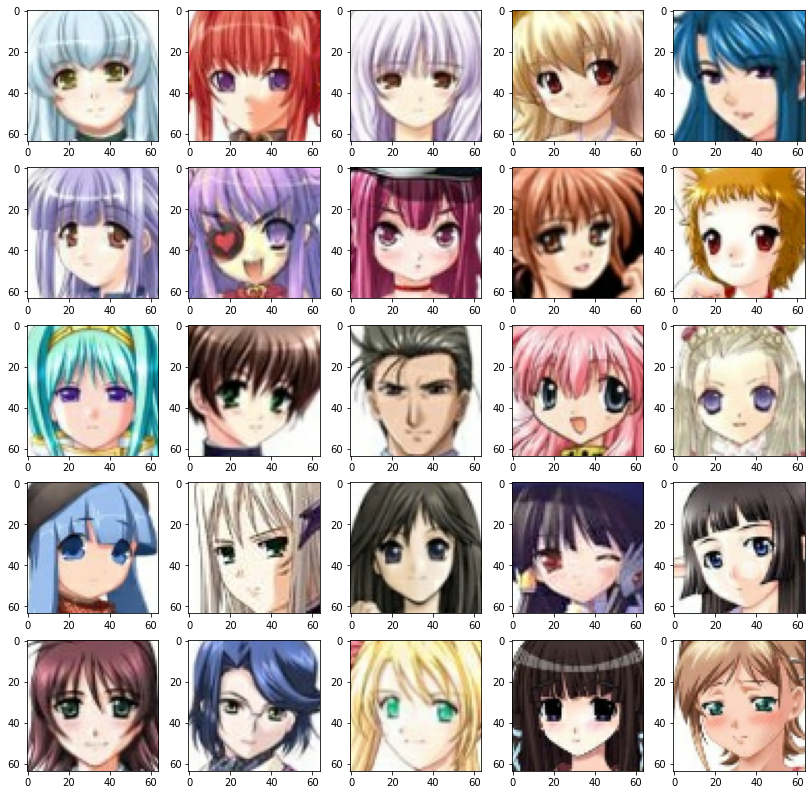

In [16]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [17]:
# build the model

latent_dim = 512

In [18]:
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

from keras import backend as K

In [19]:
K.clear_session()

In [20]:
encoder_input = Input(shape = (64,64,3))

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   51264       batch_normalization[0][0]        
____________________________________________________________________________________________

In [21]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       8

In [22]:
# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [23]:
# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 512), (None, 13802688    input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 64, 3)    13283023    encoder[0][2]                    
__________________________________________________________________________________________________
tf_op_layer_AddV2 (TensorFlowOp [(None, 512)]        0           encoder[0][1]                    
________________________________________________________________________________________________

In [24]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [ ]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

Epoch:  1
Epoch: 1 - Step: 0 - MSE loss: 0.09673679 - KL loss: 0.00031362887
Epoch: 1 - Step: 1 - MSE loss: 0.0934181 - KL loss: 0.00026665622
Epoch: 1 - Step: 2 - MSE loss: 0.09157082 - KL loss: 0.00023455678
Epoch: 1 - Step: 3 - MSE loss: 0.09003713 - KL loss: 0.00020041472
Epoch: 1 - Step: 4 - MSE loss: 0.0920991 - KL loss: 0.00016704101
Epoch: 1 - Step: 5 - MSE loss: 0.09250144 - KL loss: 0.00014489307
Epoch: 1 - Step: 6 - MSE loss: 0.090872586 - KL loss: 0.000120153614
Epoch: 1 - Step: 7 - MSE loss: 0.091801174 - KL loss: 0.00010474567
Epoch: 1 - Step: 8 - MSE loss: 0.08936533 - KL loss: 8.850024e-05
Epoch: 1 - Step: 9 - MSE loss: 0.09131124 - KL loss: 8.124671e-05
Epoch: 1 - Step: 10 - MSE loss: 0.08922892 - KL loss: 7.920018e-05
Epoch: 1 - Step: 11 - MSE loss: 0.088245966 - KL loss: 7.92504e-05
Epoch: 1 - Step: 12 - MSE loss: 0.088758685 - KL loss: 8.717512e-05
Epoch: 1 - Step: 13 - MSE loss: 0.0877707 - KL loss: 0.00010644182
Epoch: 1 - Step: 14 - MSE loss: 0.08501605 - KL loss

Epoch: 1 - Step: 124 - MSE loss: 0.046739075 - KL loss: 0.098613195
Epoch: 1 - Step: 125 - MSE loss: 0.044931486 - KL loss: 0.101519614
Epoch: 1 - Step: 126 - MSE loss: 0.04445241 - KL loss: 0.09366747
Epoch: 1 - Step: 127 - MSE loss: 0.04540619 - KL loss: 0.09393457
Epoch: 1 - Step: 128 - MSE loss: 0.04274584 - KL loss: 0.12147471
Epoch: 1 - Step: 129 - MSE loss: 0.043991167 - KL loss: 0.0963085
Epoch: 1 - Step: 130 - MSE loss: 0.043522287 - KL loss: 0.112089574
Epoch: 1 - Step: 131 - MSE loss: 0.04314177 - KL loss: 0.098569885
Epoch: 1 - Step: 132 - MSE loss: 0.04520901 - KL loss: 0.104798354
Epoch: 1 - Step: 133 - MSE loss: 0.043143656 - KL loss: 0.12492384
Epoch: 1 - Step: 134 - MSE loss: 0.046597004 - KL loss: 0.1067754
Epoch: 1 - Step: 135 - MSE loss: 0.045301314 - KL loss: 0.08563909
Epoch: 1 - Step: 136 - MSE loss: 0.04481563 - KL loss: 0.11855747
Epoch: 1 - Step: 137 - MSE loss: 0.04465462 - KL loss: 0.107469715
Epoch: 1 - Step: 138 - MSE loss: 0.040502403 - KL loss: 0.1131707

Epoch: 1 - Step: 248 - MSE loss: 0.037400644 - KL loss: 0.14241996
Epoch: 1 - Step: 249 - MSE loss: 0.037921716 - KL loss: 0.16762114
Epoch: 1 - Step: 250 - MSE loss: 0.03896549 - KL loss: 0.14218089
Epoch: 1 - Step: 251 - MSE loss: 0.036594342 - KL loss: 0.14434643
Epoch: 1 - Step: 252 - MSE loss: 0.036553476 - KL loss: 0.14754581
Epoch: 1 - Step: 253 - MSE loss: 0.036884796 - KL loss: 0.16084659
Epoch: 1 - Step: 254 - MSE loss: 0.034987208 - KL loss: 0.13962723
Epoch: 1 - Step: 255 - MSE loss: 0.036193997 - KL loss: 0.16493131
Epoch: 1 - Step: 256 - MSE loss: 0.03392395 - KL loss: 0.15771285
Epoch: 1 - Step: 257 - MSE loss: 0.0354109 - KL loss: 0.16259813
Epoch: 1 - Step: 258 - MSE loss: 0.03494468 - KL loss: 0.16752319
Epoch: 1 - Step: 259 - MSE loss: 0.034802705 - KL loss: 0.14498077
Epoch: 1 - Step: 260 - MSE loss: 0.0362708 - KL loss: 0.16794556
Epoch: 1 - Step: 261 - MSE loss: 0.03663064 - KL loss: 0.16686252
Epoch: 1 - Step: 262 - MSE loss: 0.038933612 - KL loss: 0.16623658
Epo

Epoch: 1 - Step: 372 - MSE loss: 0.031512935 - KL loss: 0.16681623
Epoch: 1 - Step: 373 - MSE loss: 0.02976563 - KL loss: 0.16571867
Epoch: 1 - Step: 374 - MSE loss: 0.029451864 - KL loss: 0.17777033
Epoch: 1 - Step: 375 - MSE loss: 0.03069303 - KL loss: 0.18728161
Epoch: 1 - Step: 376 - MSE loss: 0.03183506 - KL loss: 0.18729198
Epoch: 1 - Step: 377 - MSE loss: 0.031924825 - KL loss: 0.18757407
Epoch: 1 - Step: 378 - MSE loss: 0.03349673 - KL loss: 0.15520135
Epoch: 1 - Step: 379 - MSE loss: 0.0311109 - KL loss: 0.18032116
Epoch: 1 - Step: 380 - MSE loss: 0.030355273 - KL loss: 0.17852409
Epoch: 1 - Step: 381 - MSE loss: 0.03110627 - KL loss: 0.15546098
Epoch: 1 - Step: 382 - MSE loss: 0.0307532 - KL loss: 0.15606353
Epoch: 1 - Step: 383 - MSE loss: 0.031097718 - KL loss: 0.18822794
Epoch: 1 - Step: 384 - MSE loss: 0.033894684 - KL loss: 0.1875052
Epoch: 1 - Step: 385 - MSE loss: 0.0335763 - KL loss: 0.18553008
Epoch: 1 - Step: 386 - MSE loss: 0.0321353 - KL loss: 0.16020587
Epoch: 1 

Epoch: 2 - Step: 49 - MSE loss: 0.031919327 - KL loss: 0.20164254
Epoch: 2 - Step: 50 - MSE loss: 0.03195715 - KL loss: 0.22246647
Epoch: 2 - Step: 51 - MSE loss: 0.033154402 - KL loss: 0.1982699
Epoch: 2 - Step: 52 - MSE loss: 0.03345109 - KL loss: 0.21005574
Epoch: 2 - Step: 53 - MSE loss: 0.032724798 - KL loss: 0.19645107
Epoch: 2 - Step: 54 - MSE loss: 0.03184386 - KL loss: 0.19927128
Epoch: 2 - Step: 55 - MSE loss: 0.031926695 - KL loss: 0.21618468
Epoch: 2 - Step: 56 - MSE loss: 0.03112877 - KL loss: 0.21711121
Epoch: 2 - Step: 57 - MSE loss: 0.031190285 - KL loss: 0.20400937
Epoch: 2 - Step: 58 - MSE loss: 0.03279588 - KL loss: 0.22059688
Epoch: 2 - Step: 59 - MSE loss: 0.03174019 - KL loss: 0.22523013
Epoch: 2 - Step: 60 - MSE loss: 0.032903638 - KL loss: 0.22719756
Epoch: 2 - Step: 61 - MSE loss: 0.0337499 - KL loss: 0.18541229
Epoch: 2 - Step: 62 - MSE loss: 0.03423942 - KL loss: 0.20788282
Epoch: 2 - Step: 63 - MSE loss: 0.03243922 - KL loss: 0.19973898
Epoch: 2 - Step: 64 -

Epoch: 2 - Step: 173 - MSE loss: 0.028541507 - KL loss: 0.22365502
Epoch: 2 - Step: 174 - MSE loss: 0.029966228 - KL loss: 0.24822405
Epoch: 2 - Step: 175 - MSE loss: 0.029067757 - KL loss: 0.23019224
Epoch: 2 - Step: 176 - MSE loss: 0.028557109 - KL loss: 0.23335733
Epoch: 2 - Step: 177 - MSE loss: 0.029192438 - KL loss: 0.22612126
Epoch: 2 - Step: 178 - MSE loss: 0.029926786 - KL loss: 0.21502946
Epoch: 2 - Step: 179 - MSE loss: 0.029599255 - KL loss: 0.24472594
Epoch: 2 - Step: 180 - MSE loss: 0.027774416 - KL loss: 0.23780218
Epoch: 2 - Step: 181 - MSE loss: 0.028497973 - KL loss: 0.21586174
Epoch: 2 - Step: 182 - MSE loss: 0.028682902 - KL loss: 0.23200485
Epoch: 2 - Step: 183 - MSE loss: 0.02796644 - KL loss: 0.22648725
Epoch: 2 - Step: 184 - MSE loss: 0.027811592 - KL loss: 0.22574356
Epoch: 2 - Step: 185 - MSE loss: 0.027852261 - KL loss: 0.24211355
Epoch: 2 - Step: 186 - MSE loss: 0.028025964 - KL loss: 0.2346468
Epoch: 2 - Step: 187 - MSE loss: 0.028982827 - KL loss: 0.226088

Epoch: 2 - Step: 296 - MSE loss: 0.027464705 - KL loss: 0.22364235
Epoch: 2 - Step: 297 - MSE loss: 0.02718787 - KL loss: 0.23920341
Epoch: 2 - Step: 298 - MSE loss: 0.026848689 - KL loss: 0.24469467
Epoch: 2 - Step: 299 - MSE loss: 0.027253166 - KL loss: 0.24963197
Epoch: 2 - Step: 300 - MSE loss: 0.02734354 - KL loss: 0.22898734
Epoch: 2 - Step: 301 - MSE loss: 0.025790842 - KL loss: 0.22306648
Epoch: 2 - Step: 302 - MSE loss: 0.02621266 - KL loss: 0.23862699
Epoch: 2 - Step: 303 - MSE loss: 0.027077096 - KL loss: 0.24681726
Epoch: 2 - Step: 304 - MSE loss: 0.026819462 - KL loss: 0.24048162
Epoch: 2 - Step: 305 - MSE loss: 0.0263822 - KL loss: 0.24267143
Epoch: 2 - Step: 306 - MSE loss: 0.026336389 - KL loss: 0.24459955
Epoch: 2 - Step: 307 - MSE loss: 0.025031969 - KL loss: 0.23043242
Epoch: 2 - Step: 308 - MSE loss: 0.025649657 - KL loss: 0.2271362
Epoch: 2 - Step: 309 - MSE loss: 0.026079781 - KL loss: 0.23604006
Epoch: 2 - Step: 310 - MSE loss: 0.025073634 - KL loss: 0.21937585
E

Epoch: 2 - Step: 420 - MSE loss: 0.025530083 - KL loss: 0.2522773
Epoch: 2 - Step: 421 - MSE loss: 0.026128227 - KL loss: 0.24717467
Epoch: 2 - Step: 422 - MSE loss: 0.026312165 - KL loss: 0.23827913
Epoch: 2 - Step: 423 - MSE loss: 0.02665639 - KL loss: 0.25229567
Epoch: 2 - Step: 424 - MSE loss: 0.028051153 - KL loss: 0.234039
Epoch: 2 - Step: 425 - MSE loss: 0.02782321 - KL loss: 0.24190934
Epoch: 2 - Step: 426 - MSE loss: 0.029440606 - KL loss: 0.2540139
Epoch: 2 - Step: 427 - MSE loss: 0.02814004 - KL loss: 0.23772398
Epoch: 2 - Step: 428 - MSE loss: 0.027885048 - KL loss: 0.24347046
Epoch: 2 - Step: 429 - MSE loss: 0.028098153 - KL loss: 0.2580077
Epoch: 2 - Step: 430 - MSE loss: 0.02741802 - KL loss: 0.26426366
Epoch: 2 - Step: 431 - MSE loss: 0.026608817 - KL loss: 0.24480541
Epoch: 2 - Step: 432 - MSE loss: 0.027419657 - KL loss: 0.2486422
Epoch: 2 - Step: 433 - MSE loss: 0.025723094 - KL loss: 0.23923942
Epoch: 2 - Step: 434 - MSE loss: 0.025963299 - KL loss: 0.25287825
Epoch

Epoch: 3 - Step: 98 - MSE loss: 0.026400732 - KL loss: 0.24828531
Epoch: 3 - Step: 99 - MSE loss: 0.025853679 - KL loss: 0.2575369
Epoch: 3 - Step: 100 - MSE loss: 0.026910638 - KL loss: 0.24937733
Epoch: 3 - Step: 101 - MSE loss: 0.026460694 - KL loss: 0.2453247
Epoch: 3 - Step: 102 - MSE loss: 0.026335495 - KL loss: 0.2570838
Epoch: 3 - Step: 103 - MSE loss: 0.026242403 - KL loss: 0.2624942
Epoch: 3 - Step: 104 - MSE loss: 0.026230767 - KL loss: 0.24485375
Epoch: 3 - Step: 105 - MSE loss: 0.025444672 - KL loss: 0.26618573
Epoch: 3 - Step: 106 - MSE loss: 0.026227413 - KL loss: 0.24552917
Epoch: 3 - Step: 107 - MSE loss: 0.026637537 - KL loss: 0.27658898
Epoch: 3 - Step: 108 - MSE loss: 0.027218267 - KL loss: 0.25179875
Epoch: 3 - Step: 109 - MSE loss: 0.02763375 - KL loss: 0.25169778
Epoch: 3 - Step: 110 - MSE loss: 0.025192311 - KL loss: 0.24043882
Epoch: 3 - Step: 111 - MSE loss: 0.026440285 - KL loss: 0.23454994
Epoch: 3 - Step: 112 - MSE loss: 0.026660675 - KL loss: 0.23753801
Ep

Epoch: 3 - Step: 222 - MSE loss: 0.025062328 - KL loss: 0.2546478
Epoch: 3 - Step: 223 - MSE loss: 0.025104651 - KL loss: 0.27012223
Epoch: 3 - Step: 224 - MSE loss: 0.023804972 - KL loss: 0.25979558
Epoch: 3 - Step: 225 - MSE loss: 0.025440551 - KL loss: 0.2605989
Epoch: 3 - Step: 226 - MSE loss: 0.025351882 - KL loss: 0.28234974
Epoch: 3 - Step: 227 - MSE loss: 0.025935294 - KL loss: 0.25334167
Epoch: 3 - Step: 228 - MSE loss: 0.026668446 - KL loss: 0.24446496
Epoch: 3 - Step: 229 - MSE loss: 0.025940761 - KL loss: 0.28759238
Epoch: 3 - Step: 230 - MSE loss: 0.026133748 - KL loss: 0.24737895
Epoch: 3 - Step: 231 - MSE loss: 0.024594722 - KL loss: 0.22565262
Epoch: 3 - Step: 232 - MSE loss: 0.025378697 - KL loss: 0.26747385
Epoch: 3 - Step: 233 - MSE loss: 0.024943376 - KL loss: 0.25541517
Epoch: 3 - Step: 234 - MSE loss: 0.024755051 - KL loss: 0.24831472
Epoch: 3 - Step: 235 - MSE loss: 0.024372831 - KL loss: 0.24629912
Epoch: 3 - Step: 236 - MSE loss: 0.025227986 - KL loss: 0.258784

Epoch: 3 - Step: 346 - MSE loss: 0.022057349 - KL loss: 0.2521839
Epoch: 3 - Step: 347 - MSE loss: 0.022561816 - KL loss: 0.252458
Epoch: 3 - Step: 348 - MSE loss: 0.023011433 - KL loss: 0.26684785
Epoch: 3 - Step: 349 - MSE loss: 0.02334152 - KL loss: 0.25914362
Epoch: 3 - Step: 350 - MSE loss: 0.022537647 - KL loss: 0.24678501
Epoch: 3 - Step: 351 - MSE loss: 0.023072973 - KL loss: 0.24882212
Epoch: 3 - Step: 352 - MSE loss: 0.023047686 - KL loss: 0.25412828
Epoch: 3 - Step: 353 - MSE loss: 0.024172664 - KL loss: 0.23116228
Epoch: 3 - Step: 354 - MSE loss: 0.023635084 - KL loss: 0.26522326
Epoch: 3 - Step: 355 - MSE loss: 0.02181921 - KL loss: 0.26498032
Epoch: 3 - Step: 356 - MSE loss: 0.022493968 - KL loss: 0.24445122
Epoch: 3 - Step: 357 - MSE loss: 0.022267202 - KL loss: 0.27181584
Epoch: 3 - Step: 358 - MSE loss: 0.02204275 - KL loss: 0.23532695
Epoch: 3 - Step: 359 - MSE loss: 0.022596626 - KL loss: 0.25005233
Epoch: 3 - Step: 360 - MSE loss: 0.022456495 - KL loss: 0.24703178
E

Epoch: 4 - Step: 146 - MSE loss: 0.023999704 - KL loss: 0.2559741
Epoch: 4 - Step: 147 - MSE loss: 0.02348063 - KL loss: 0.2622664
Epoch: 4 - Step: 148 - MSE loss: 0.02351916 - KL loss: 0.2486355
Epoch: 4 - Step: 149 - MSE loss: 0.023273326 - KL loss: 0.2667678
Epoch: 4 - Step: 150 - MSE loss: 0.02411259 - KL loss: 0.2754916
Epoch: 4 - Step: 151 - MSE loss: 0.02378551 - KL loss: 0.25363284
Epoch: 4 - Step: 152 - MSE loss: 0.024624383 - KL loss: 0.26614374
Epoch: 4 - Step: 153 - MSE loss: 0.025094226 - KL loss: 0.26466697
Epoch: 4 - Step: 154 - MSE loss: 0.025143415 - KL loss: 0.26052484
Epoch: 4 - Step: 155 - MSE loss: 0.024665577 - KL loss: 0.23806342
Epoch: 4 - Step: 156 - MSE loss: 0.023340816 - KL loss: 0.26384994
Epoch: 4 - Step: 157 - MSE loss: 0.023381656 - KL loss: 0.26291922
Epoch: 4 - Step: 158 - MSE loss: 0.024367528 - KL loss: 0.2728874
Epoch: 4 - Step: 159 - MSE loss: 0.025741333 - KL loss: 0.28564996
Epoch: 4 - Step: 160 - MSE loss: 0.022965863 - KL loss: 0.25862148
Epoch

Epoch: 4 - Step: 270 - MSE loss: 0.02171578 - KL loss: 0.2592178
Epoch: 4 - Step: 271 - MSE loss: 0.021812638 - KL loss: 0.26620954
Epoch: 4 - Step: 272 - MSE loss: 0.02223841 - KL loss: 0.26055622
Epoch: 4 - Step: 273 - MSE loss: 0.021496141 - KL loss: 0.2599696
Epoch: 4 - Step: 274 - MSE loss: 0.02208207 - KL loss: 0.24054661
Epoch: 4 - Step: 275 - MSE loss: 0.021666618 - KL loss: 0.26666206
Epoch: 4 - Step: 276 - MSE loss: 0.021014258 - KL loss: 0.2558357
Epoch: 4 - Step: 277 - MSE loss: 0.021379476 - KL loss: 0.2695042
Epoch: 4 - Step: 278 - MSE loss: 0.021681823 - KL loss: 0.25466445
Epoch: 4 - Step: 279 - MSE loss: 0.02169378 - KL loss: 0.25959772
Epoch: 4 - Step: 280 - MSE loss: 0.021522477 - KL loss: 0.25046435
Epoch: 4 - Step: 281 - MSE loss: 0.021996165 - KL loss: 0.26394236
Epoch: 4 - Step: 282 - MSE loss: 0.022152945 - KL loss: 0.25319958
Epoch: 4 - Step: 283 - MSE loss: 0.021185247 - KL loss: 0.24639654
Epoch: 4 - Step: 284 - MSE loss: 0.02153791 - KL loss: 0.24030192
Epoc

Epoch: 4 - Step: 394 - MSE loss: 0.021743834 - KL loss: 0.2486065
Epoch: 4 - Step: 395 - MSE loss: 0.020404156 - KL loss: 0.25328508
Epoch: 4 - Step: 396 - MSE loss: 0.021383608 - KL loss: 0.24748723
Epoch: 4 - Step: 397 - MSE loss: 0.020317305 - KL loss: 0.2473014
Epoch: 4 - Step: 398 - MSE loss: 0.020264221 - KL loss: 0.24725172
Epoch: 4 - Step: 399 - MSE loss: 0.020892838 - KL loss: 0.25874493
Epoch: 4 - Step: 400 - MSE loss: 0.021262236 - KL loss: 0.24669763
Epoch: 4 - Step: 401 - MSE loss: 0.02200286 - KL loss: 0.24247
Epoch: 4 - Step: 402 - MSE loss: 0.022045786 - KL loss: 0.24902871
Epoch: 4 - Step: 403 - MSE loss: 0.020956144 - KL loss: 0.2605563
Epoch: 4 - Step: 404 - MSE loss: 0.021231117 - KL loss: 0.25359532
Epoch: 4 - Step: 405 - MSE loss: 0.021812357 - KL loss: 0.24777758
Epoch: 4 - Step: 406 - MSE loss: 0.021138482 - KL loss: 0.2471401
Epoch: 4 - Step: 407 - MSE loss: 0.020604009 - KL loss: 0.26446947
Epoch: 4 - Step: 408 - MSE loss: 0.021274598 - KL loss: 0.24008675
Epo

Epoch: 5 - Step: 71 - MSE loss: 0.022886992 - KL loss: 0.2648982
Epoch: 5 - Step: 72 - MSE loss: 0.023585036 - KL loss: 0.27427548
Epoch: 5 - Step: 73 - MSE loss: 0.022885436 - KL loss: 0.25825816
Epoch: 5 - Step: 74 - MSE loss: 0.023014126 - KL loss: 0.2655924
Epoch: 5 - Step: 75 - MSE loss: 0.021835834 - KL loss: 0.25706035
Epoch: 5 - Step: 76 - MSE loss: 0.022554666 - KL loss: 0.25256407
Epoch: 5 - Step: 77 - MSE loss: 0.022709481 - KL loss: 0.2572541
Epoch: 5 - Step: 78 - MSE loss: 0.02371314 - KL loss: 0.24867454
Epoch: 5 - Step: 79 - MSE loss: 0.02286864 - KL loss: 0.28163502
Epoch: 5 - Step: 80 - MSE loss: 0.023446748 - KL loss: 0.25019222
Epoch: 5 - Step: 81 - MSE loss: 0.024557196 - KL loss: 0.2612968
Epoch: 5 - Step: 82 - MSE loss: 0.023975804 - KL loss: 0.24902853
Epoch: 5 - Step: 83 - MSE loss: 0.023922114 - KL loss: 0.24077392
Epoch: 5 - Step: 84 - MSE loss: 0.024145192 - KL loss: 0.2687362
Epoch: 5 - Step: 85 - MSE loss: 0.022945521 - KL loss: 0.2734689
Epoch: 5 - Step: 8

Epoch: 5 - Step: 195 - MSE loss: 0.02208685 - KL loss: 0.24411699
Epoch: 5 - Step: 196 - MSE loss: 0.02177153 - KL loss: 0.2578274
Epoch: 5 - Step: 197 - MSE loss: 0.02246931 - KL loss: 0.26114562
Epoch: 5 - Step: 198 - MSE loss: 0.024047563 - KL loss: 0.26478565
Epoch: 5 - Step: 199 - MSE loss: 0.023657357 - KL loss: 0.23951128
Epoch: 5 - Step: 200 - MSE loss: 0.022453947 - KL loss: 0.27321076
Epoch: 5 - Step: 201 - MSE loss: 0.022545883 - KL loss: 0.26603752
Epoch: 5 - Step: 202 - MSE loss: 0.021403171 - KL loss: 0.25454664
Epoch: 5 - Step: 203 - MSE loss: 0.021533096 - KL loss: 0.25225836
Epoch: 5 - Step: 204 - MSE loss: 0.02180899 - KL loss: 0.25435436
Epoch: 5 - Step: 205 - MSE loss: 0.022813626 - KL loss: 0.26613098
Epoch: 5 - Step: 206 - MSE loss: 0.021531777 - KL loss: 0.2571514
Epoch: 5 - Step: 207 - MSE loss: 0.021254988 - KL loss: 0.2737407
Epoch: 5 - Step: 208 - MSE loss: 0.021077996 - KL loss: 0.26168478
Epoch: 5 - Step: 209 - MSE loss: 0.021855189 - KL loss: 0.2563427
Epo

Epoch: 5 - Step: 319 - MSE loss: 0.020294808 - KL loss: 0.24876691
Epoch: 5 - Step: 320 - MSE loss: 0.020017268 - KL loss: 0.24699847
Epoch: 5 - Step: 321 - MSE loss: 0.019251345 - KL loss: 0.25152397
Epoch: 5 - Step: 322 - MSE loss: 0.019682182 - KL loss: 0.24543157
Epoch: 5 - Step: 323 - MSE loss: 0.018850481 - KL loss: 0.24845056
Epoch: 5 - Step: 324 - MSE loss: 0.01960761 - KL loss: 0.2480537
Epoch: 5 - Step: 325 - MSE loss: 0.019173773 - KL loss: 0.2475422
Epoch: 5 - Step: 326 - MSE loss: 0.019622589 - KL loss: 0.25677326
Epoch: 5 - Step: 327 - MSE loss: 0.020439154 - KL loss: 0.25116014
Epoch: 5 - Step: 328 - MSE loss: 0.01951077 - KL loss: 0.24767624
Epoch: 5 - Step: 329 - MSE loss: 0.020621024 - KL loss: 0.25649902
Epoch: 5 - Step: 330 - MSE loss: 0.02009316 - KL loss: 0.25884154
Epoch: 5 - Step: 331 - MSE loss: 0.020410454 - KL loss: 0.25640607
Epoch: 5 - Step: 332 - MSE loss: 0.020041116 - KL loss: 0.24954587
Epoch: 5 - Step: 333 - MSE loss: 0.019831544 - KL loss: 0.24808764


Epoch: 5 - Step: 443 - MSE loss: 0.02157131 - KL loss: 0.25953555
Epoch: 5 - Step: 444 - MSE loss: 0.022707084 - KL loss: 0.27427235
Epoch: 5 - Step: 445 - MSE loss: 0.021330593 - KL loss: 0.26060733
Epoch: 5 - Step: 446 - MSE loss: 0.021173293 - KL loss: 0.26993474
Epoch: 5 - Step: 447 - MSE loss: 0.023089869 - KL loss: 0.25899246
Epoch:  6
Epoch: 6 - Step: 0 - MSE loss: 0.022575812 - KL loss: 0.27666575
Epoch: 6 - Step: 1 - MSE loss: 0.021860892 - KL loss: 0.26344693
Epoch: 6 - Step: 2 - MSE loss: 0.021143878 - KL loss: 0.25874725
Epoch: 6 - Step: 3 - MSE loss: 0.021458259 - KL loss: 0.26379156
Epoch: 6 - Step: 4 - MSE loss: 0.021560883 - KL loss: 0.26185814
Epoch: 6 - Step: 5 - MSE loss: 0.020365356 - KL loss: 0.26628065
Epoch: 6 - Step: 6 - MSE loss: 0.021589026 - KL loss: 0.26581457
Epoch: 6 - Step: 7 - MSE loss: 0.021674646 - KL loss: 0.2534319
Epoch: 6 - Step: 8 - MSE loss: 0.021031007 - KL loss: 0.26094362
Epoch: 6 - Step: 9 - MSE loss: 0.021191716 - KL loss: 0.27146322
Epoch: 

Epoch: 6 - Step: 120 - MSE loss: 0.0201632 - KL loss: 0.24746643
Epoch: 6 - Step: 121 - MSE loss: 0.022239024 - KL loss: 0.2638498
Epoch: 6 - Step: 122 - MSE loss: 0.019643748 - KL loss: 0.25967076
Epoch: 6 - Step: 123 - MSE loss: 0.020867497 - KL loss: 0.25448745
Epoch: 6 - Step: 124 - MSE loss: 0.021053793 - KL loss: 0.26199582
Epoch: 6 - Step: 125 - MSE loss: 0.020949213 - KL loss: 0.26743954
Epoch: 6 - Step: 126 - MSE loss: 0.020522919 - KL loss: 0.26340207
Epoch: 6 - Step: 127 - MSE loss: 0.02045427 - KL loss: 0.25541902
Epoch: 6 - Step: 128 - MSE loss: 0.020591693 - KL loss: 0.25838363
Epoch: 6 - Step: 129 - MSE loss: 0.020017596 - KL loss: 0.25393456
Epoch: 6 - Step: 130 - MSE loss: 0.020456327 - KL loss: 0.26287234
Epoch: 6 - Step: 131 - MSE loss: 0.019993152 - KL loss: 0.25498423
Epoch: 6 - Step: 132 - MSE loss: 0.01976726 - KL loss: 0.25364524
Epoch: 6 - Step: 133 - MSE loss: 0.020279512 - KL loss: 0.25643194
Epoch: 6 - Step: 134 - MSE loss: 0.020470465 - KL loss: 0.2538541
E

Epoch: 6 - Step: 244 - MSE loss: 0.019738747 - KL loss: 0.25490785
Epoch: 6 - Step: 245 - MSE loss: 0.020970186 - KL loss: 0.2573568
Epoch: 6 - Step: 246 - MSE loss: 0.019163014 - KL loss: 0.2502775
Epoch: 6 - Step: 247 - MSE loss: 0.01960001 - KL loss: 0.2631551
Epoch: 6 - Step: 248 - MSE loss: 0.019247467 - KL loss: 0.25992087
Epoch: 6 - Step: 249 - MSE loss: 0.020360125 - KL loss: 0.25656784
Epoch: 6 - Step: 250 - MSE loss: 0.019492017 - KL loss: 0.2615654
Epoch: 6 - Step: 251 - MSE loss: 0.019579785 - KL loss: 0.25930104
Epoch: 6 - Step: 252 - MSE loss: 0.018975852 - KL loss: 0.25831732
Epoch: 6 - Step: 253 - MSE loss: 0.020213386 - KL loss: 0.25728136
Epoch: 6 - Step: 254 - MSE loss: 0.019565733 - KL loss: 0.2587828
Epoch: 6 - Step: 255 - MSE loss: 0.020351838 - KL loss: 0.26055717
Epoch: 6 - Step: 256 - MSE loss: 0.019804575 - KL loss: 0.24454999
Epoch: 6 - Step: 257 - MSE loss: 0.019405441 - KL loss: 0.2565266
Epoch: 6 - Step: 258 - MSE loss: 0.020065526 - KL loss: 0.25852704
Ep

Epoch: 6 - Step: 368 - MSE loss: 0.01764607 - KL loss: 0.23585501
Epoch: 6 - Step: 369 - MSE loss: 0.01774514 - KL loss: 0.2518084
Epoch: 6 - Step: 370 - MSE loss: 0.017497836 - KL loss: 0.24957708
Epoch: 6 - Step: 371 - MSE loss: 0.018273288 - KL loss: 0.25434396
Epoch: 6 - Step: 372 - MSE loss: 0.018643746 - KL loss: 0.24318878
Epoch: 6 - Step: 373 - MSE loss: 0.018006783 - KL loss: 0.24880703
Epoch: 6 - Step: 374 - MSE loss: 0.017356249 - KL loss: 0.23581418
Epoch: 6 - Step: 375 - MSE loss: 0.018063484 - KL loss: 0.25683182
Epoch: 6 - Step: 376 - MSE loss: 0.019104807 - KL loss: 0.24142824
Epoch: 6 - Step: 377 - MSE loss: 0.018932413 - KL loss: 0.24618477
Epoch: 6 - Step: 378 - MSE loss: 0.018594092 - KL loss: 0.22823986
Epoch: 6 - Step: 379 - MSE loss: 0.017705308 - KL loss: 0.25301456
Epoch: 6 - Step: 380 - MSE loss: 0.019227521 - KL loss: 0.24738207
Epoch: 6 - Step: 381 - MSE loss: 0.018247282 - KL loss: 0.24663301
Epoch: 6 - Step: 382 - MSE loss: 0.017684564 - KL loss: 0.2553463

Epoch: 7 - Step: 44 - MSE loss: 0.02060045 - KL loss: 0.24416927
Epoch: 7 - Step: 45 - MSE loss: 0.02121169 - KL loss: 0.2665834
Epoch: 7 - Step: 46 - MSE loss: 0.021957576 - KL loss: 0.2584619
Epoch: 7 - Step: 47 - MSE loss: 0.021445213 - KL loss: 0.27466512
Epoch: 7 - Step: 48 - MSE loss: 0.021517074 - KL loss: 0.2652201
Epoch: 7 - Step: 49 - MSE loss: 0.019719305 - KL loss: 0.25945425
Epoch: 7 - Step: 50 - MSE loss: 0.020622214 - KL loss: 0.26279086
Epoch: 7 - Step: 51 - MSE loss: 0.02056636 - KL loss: 0.2520924
Epoch: 7 - Step: 52 - MSE loss: 0.021476628 - KL loss: 0.27099323
Epoch: 7 - Step: 53 - MSE loss: 0.02111462 - KL loss: 0.2606327
Epoch: 7 - Step: 54 - MSE loss: 0.021514734 - KL loss: 0.26679772
Epoch: 7 - Step: 55 - MSE loss: 0.021107843 - KL loss: 0.26796526
Epoch: 7 - Step: 56 - MSE loss: 0.021626508 - KL loss: 0.26396543
Epoch: 7 - Step: 57 - MSE loss: 0.021234035 - KL loss: 0.25790247
Epoch: 7 - Step: 58 - MSE loss: 0.02061331 - KL loss: 0.27145424
Epoch: 7 - Step: 59 

Epoch: 7 - Step: 169 - MSE loss: 0.019513618 - KL loss: 0.26143897
Epoch: 7 - Step: 170 - MSE loss: 0.02029161 - KL loss: 0.2710292
Epoch: 7 - Step: 171 - MSE loss: 0.01905862 - KL loss: 0.2568369
Epoch: 7 - Step: 172 - MSE loss: 0.019518234 - KL loss: 0.2667609
Epoch: 7 - Step: 173 - MSE loss: 0.020140754 - KL loss: 0.2577151
Epoch: 7 - Step: 174 - MSE loss: 0.02055782 - KL loss: 0.26921517
Epoch: 7 - Step: 175 - MSE loss: 0.020426456 - KL loss: 0.25683832
Epoch: 7 - Step: 176 - MSE loss: 0.02004163 - KL loss: 0.26315534
Epoch: 7 - Step: 177 - MSE loss: 0.01962568 - KL loss: 0.25616917
Epoch: 7 - Step: 178 - MSE loss: 0.019848181 - KL loss: 0.2687742
Epoch: 7 - Step: 179 - MSE loss: 0.019265857 - KL loss: 0.2575926
Epoch: 7 - Step: 180 - MSE loss: 0.019940332 - KL loss: 0.25599366
Epoch: 7 - Step: 181 - MSE loss: 0.019856127 - KL loss: 0.2722864
Epoch: 7 - Step: 182 - MSE loss: 0.019570302 - KL loss: 0.2689702
Epoch: 7 - Step: 183 - MSE loss: 0.01892051 - KL loss: 0.2550285
Epoch: 7 -

Epoch: 7 - Step: 293 - MSE loss: 0.017972052 - KL loss: 0.24900982
Epoch: 7 - Step: 294 - MSE loss: 0.017677132 - KL loss: 0.25634018
Epoch: 7 - Step: 295 - MSE loss: 0.01708795 - KL loss: 0.25548834
Epoch: 7 - Step: 296 - MSE loss: 0.018067596 - KL loss: 0.2675959
Epoch: 7 - Step: 297 - MSE loss: 0.018432578 - KL loss: 0.2537362
Epoch: 7 - Step: 298 - MSE loss: 0.0181923 - KL loss: 0.25615096
Epoch: 7 - Step: 299 - MSE loss: 0.01886231 - KL loss: 0.26326722
Epoch: 7 - Step: 300 - MSE loss: 0.01861849 - KL loss: 0.24422762
Epoch: 7 - Step: 301 - MSE loss: 0.017797325 - KL loss: 0.263219
Epoch: 7 - Step: 302 - MSE loss: 0.017814515 - KL loss: 0.25600773
Epoch: 7 - Step: 303 - MSE loss: 0.018925585 - KL loss: 0.28029233
Epoch: 7 - Step: 304 - MSE loss: 0.018767057 - KL loss: 0.26064745
Epoch: 7 - Step: 305 - MSE loss: 0.02058226 - KL loss: 0.25034297
Epoch: 7 - Step: 306 - MSE loss: 0.018743457 - KL loss: 0.23827177
Epoch: 7 - Step: 307 - MSE loss: 0.018904058 - KL loss: 0.25619173
Epoch

Epoch: 7 - Step: 417 - MSE loss: 0.017189603 - KL loss: 0.2540245
Epoch: 7 - Step: 418 - MSE loss: 0.016739616 - KL loss: 0.2561438
Epoch: 7 - Step: 419 - MSE loss: 0.01743436 - KL loss: 0.24614525
Epoch: 7 - Step: 420 - MSE loss: 0.01795706 - KL loss: 0.25223202
Epoch: 7 - Step: 421 - MSE loss: 0.01773914 - KL loss: 0.2580003
Epoch: 7 - Step: 422 - MSE loss: 0.01830334 - KL loss: 0.2576682
Epoch: 7 - Step: 423 - MSE loss: 0.019111909 - KL loss: 0.26122543
Epoch: 7 - Step: 424 - MSE loss: 0.018395254 - KL loss: 0.271902
Epoch: 7 - Step: 425 - MSE loss: 0.019558975 - KL loss: 0.27289772
Epoch: 7 - Step: 426 - MSE loss: 0.019104743 - KL loss: 0.26165122
Epoch: 7 - Step: 427 - MSE loss: 0.01905291 - KL loss: 0.25631985
Epoch: 7 - Step: 428 - MSE loss: 0.0196091 - KL loss: 0.26550198
Epoch: 7 - Step: 429 - MSE loss: 0.01976581 - KL loss: 0.26278725
Epoch: 7 - Step: 430 - MSE loss: 0.019780045 - KL loss: 0.25850525
Epoch: 7 - Step: 431 - MSE loss: 0.019206462 - KL loss: 0.2737946
Epoch: 7 -

Epoch: 8 - Step: 94 - MSE loss: 0.018714152 - KL loss: 0.27016163
Epoch: 8 - Step: 95 - MSE loss: 0.019252935 - KL loss: 0.26786733
Epoch: 8 - Step: 96 - MSE loss: 0.01959964 - KL loss: 0.27230635
Epoch: 8 - Step: 97 - MSE loss: 0.017751059 - KL loss: 0.26409167
Epoch: 8 - Step: 98 - MSE loss: 0.018488586 - KL loss: 0.26276952
Epoch: 8 - Step: 99 - MSE loss: 0.01850302 - KL loss: 0.26732898
Epoch: 8 - Step: 100 - MSE loss: 0.019483693 - KL loss: 0.26450092
Epoch: 8 - Step: 101 - MSE loss: 0.018868823 - KL loss: 0.2672248
Epoch: 8 - Step: 102 - MSE loss: 0.018269422 - KL loss: 0.2615197
Epoch: 8 - Step: 103 - MSE loss: 0.019000456 - KL loss: 0.26721695
Epoch: 8 - Step: 104 - MSE loss: 0.019511664 - KL loss: 0.2696217
Epoch: 8 - Step: 105 - MSE loss: 0.019259693 - KL loss: 0.26240492
Epoch: 8 - Step: 106 - MSE loss: 0.019452145 - KL loss: 0.2752759
Epoch: 8 - Step: 107 - MSE loss: 0.017976245 - KL loss: 0.26082933
Epoch: 8 - Step: 108 - MSE loss: 0.018855624 - KL loss: 0.2735424
Epoch: 8

Epoch: 8 - Step: 218 - MSE loss: 0.01814427 - KL loss: 0.26398742
Epoch: 8 - Step: 219 - MSE loss: 0.018102085 - KL loss: 0.26104185
Epoch: 8 - Step: 220 - MSE loss: 0.01905778 - KL loss: 0.26361847
Epoch: 8 - Step: 221 - MSE loss: 0.017617824 - KL loss: 0.2626553
Epoch: 8 - Step: 222 - MSE loss: 0.018544747 - KL loss: 0.26092184
Epoch: 8 - Step: 223 - MSE loss: 0.019033613 - KL loss: 0.26940244
Epoch: 8 - Step: 224 - MSE loss: 0.01867361 - KL loss: 0.25590074
Epoch: 8 - Step: 225 - MSE loss: 0.018052965 - KL loss: 0.2649461
Epoch: 8 - Step: 226 - MSE loss: 0.019501636 - KL loss: 0.25765866
Epoch: 8 - Step: 227 - MSE loss: 0.020640764 - KL loss: 0.26839548
Epoch: 8 - Step: 228 - MSE loss: 0.019787993 - KL loss: 0.268726
Epoch: 8 - Step: 229 - MSE loss: 0.019627878 - KL loss: 0.25405505
Epoch: 8 - Step: 230 - MSE loss: 0.018838402 - KL loss: 0.26531586
Epoch: 8 - Step: 231 - MSE loss: 0.01886323 - KL loss: 0.26450077
Epoch: 8 - Step: 232 - MSE loss: 0.018707735 - KL loss: 0.25570768
Epo

Epoch: 9 - Step: 18 - MSE loss: 0.018557362 - KL loss: 0.27925235
Epoch: 9 - Step: 19 - MSE loss: 0.017963935 - KL loss: 0.2703449
Epoch: 9 - Step: 20 - MSE loss: 0.019318027 - KL loss: 0.27108797
Epoch: 9 - Step: 21 - MSE loss: 0.0186438 - KL loss: 0.2669475
Epoch: 9 - Step: 22 - MSE loss: 0.019521432 - KL loss: 0.27088523
Epoch: 9 - Step: 23 - MSE loss: 0.019161249 - KL loss: 0.26734847
Epoch: 9 - Step: 24 - MSE loss: 0.018403875 - KL loss: 0.28467923
Epoch: 9 - Step: 25 - MSE loss: 0.020017337 - KL loss: 0.28060526
Epoch: 9 - Step: 26 - MSE loss: 0.01896596 - KL loss: 0.27691305
Epoch: 9 - Step: 27 - MSE loss: 0.019282008 - KL loss: 0.27472186
Epoch: 9 - Step: 28 - MSE loss: 0.018756744 - KL loss: 0.27266565
Epoch: 9 - Step: 29 - MSE loss: 0.018964237 - KL loss: 0.26577938
Epoch: 9 - Step: 30 - MSE loss: 0.018675238 - KL loss: 0.270814
Epoch: 9 - Step: 31 - MSE loss: 0.019603284 - KL loss: 0.2766207
Epoch: 9 - Step: 32 - MSE loss: 0.018664194 - KL loss: 0.26849473
Epoch: 9 - Step: 3

Epoch: 9 - Step: 143 - MSE loss: 0.017858883 - KL loss: 0.2610799
Epoch: 9 - Step: 144 - MSE loss: 0.018533502 - KL loss: 0.27273786
Epoch: 9 - Step: 145 - MSE loss: 0.017806215 - KL loss: 0.2643246
Epoch: 9 - Step: 146 - MSE loss: 0.01785378 - KL loss: 0.2531098
Epoch: 9 - Step: 147 - MSE loss: 0.018271916 - KL loss: 0.28015867
Epoch: 9 - Step: 148 - MSE loss: 0.01843671 - KL loss: 0.26392248
Epoch: 9 - Step: 149 - MSE loss: 0.0187895 - KL loss: 0.26901317
Epoch: 9 - Step: 150 - MSE loss: 0.018124832 - KL loss: 0.27855837
Epoch: 9 - Step: 151 - MSE loss: 0.018265417 - KL loss: 0.26596528
Epoch: 9 - Step: 152 - MSE loss: 0.018779663 - KL loss: 0.27536565
Epoch: 9 - Step: 153 - MSE loss: 0.01876668 - KL loss: 0.2761383
Epoch: 9 - Step: 154 - MSE loss: 0.018690499 - KL loss: 0.26833668
Epoch: 9 - Step: 155 - MSE loss: 0.018845735 - KL loss: 0.26378506
Epoch: 9 - Step: 156 - MSE loss: 0.019126909 - KL loss: 0.2755286
Epoch: 9 - Step: 157 - MSE loss: 0.01726621 - KL loss: 0.26631126
Epoch:

Epoch: 9 - Step: 267 - MSE loss: 0.0173984 - KL loss: 0.27637386
Epoch: 9 - Step: 268 - MSE loss: 0.01619529 - KL loss: 0.25720257
Epoch: 9 - Step: 269 - MSE loss: 0.01708819 - KL loss: 0.27208868
Epoch: 9 - Step: 270 - MSE loss: 0.016905816 - KL loss: 0.2638207
Epoch: 9 - Step: 271 - MSE loss: 0.015585302 - KL loss: 0.26031142
Epoch: 9 - Step: 272 - MSE loss: 0.01680711 - KL loss: 0.26615208
Epoch: 9 - Step: 273 - MSE loss: 0.01710871 - KL loss: 0.26856565
Epoch: 9 - Step: 274 - MSE loss: 0.017407607 - KL loss: 0.2636033
Epoch: 9 - Step: 275 - MSE loss: 0.016872447 - KL loss: 0.2588182
Epoch: 9 - Step: 276 - MSE loss: 0.016485265 - KL loss: 0.25921997
Epoch: 9 - Step: 277 - MSE loss: 0.016760401 - KL loss: 0.26146284
Epoch: 9 - Step: 278 - MSE loss: 0.016456129 - KL loss: 0.2504586
Epoch: 9 - Step: 279 - MSE loss: 0.017300555 - KL loss: 0.27111116
Epoch: 9 - Step: 280 - MSE loss: 0.016413065 - KL loss: 0.25777444
Epoch: 9 - Step: 281 - MSE loss: 0.016924778 - KL loss: 0.2602514
Epoch:

Epoch: 9 - Step: 391 - MSE loss: 0.016499264 - KL loss: 0.2500454
Epoch: 9 - Step: 392 - MSE loss: 0.01648817 - KL loss: 0.25556484
Epoch: 9 - Step: 393 - MSE loss: 0.018292889 - KL loss: 0.26324505
Epoch: 9 - Step: 394 - MSE loss: 0.017040044 - KL loss: 0.26632774
Epoch: 9 - Step: 395 - MSE loss: 0.01780947 - KL loss: 0.24604724
Epoch: 9 - Step: 396 - MSE loss: 0.016601952 - KL loss: 0.24650732
Epoch: 9 - Step: 397 - MSE loss: 0.0166344 - KL loss: 0.26056597
Epoch: 9 - Step: 398 - MSE loss: 0.01644762 - KL loss: 0.2509277
Epoch: 9 - Step: 399 - MSE loss: 0.01686405 - KL loss: 0.26252544
Epoch: 9 - Step: 400 - MSE loss: 0.015927782 - KL loss: 0.25966743
Epoch: 9 - Step: 401 - MSE loss: 0.015867975 - KL loss: 0.25507253
Epoch: 9 - Step: 402 - MSE loss: 0.017318605 - KL loss: 0.25724798
Epoch: 9 - Step: 403 - MSE loss: 0.01580961 - KL loss: 0.26455927
Epoch: 9 - Step: 404 - MSE loss: 0.017572513 - KL loss: 0.27057558
Epoch: 9 - Step: 405 - MSE loss: 0.016626734 - KL loss: 0.25684226
Epoc

Epoch: 10 - Step: 67 - MSE loss: 0.018622218 - KL loss: 0.26989958
Epoch: 10 - Step: 68 - MSE loss: 0.018690158 - KL loss: 0.27217066
Epoch: 10 - Step: 69 - MSE loss: 0.018756244 - KL loss: 0.27057773
Epoch: 10 - Step: 70 - MSE loss: 0.018395191 - KL loss: 0.27282962
Epoch: 10 - Step: 71 - MSE loss: 0.017571945 - KL loss: 0.27322865
Epoch: 10 - Step: 72 - MSE loss: 0.018771438 - KL loss: 0.27908847
Epoch: 10 - Step: 73 - MSE loss: 0.018213592 - KL loss: 0.2863859
Epoch: 10 - Step: 74 - MSE loss: 0.018723698 - KL loss: 0.27536136
Epoch: 10 - Step: 75 - MSE loss: 0.018543204 - KL loss: 0.2701422
Epoch: 10 - Step: 76 - MSE loss: 0.01751875 - KL loss: 0.26809442
Epoch: 10 - Step: 77 - MSE loss: 0.017804997 - KL loss: 0.26502007
Epoch: 10 - Step: 78 - MSE loss: 0.018085865 - KL loss: 0.2729675
Epoch: 10 - Step: 79 - MSE loss: 0.018728537 - KL loss: 0.2765687
Epoch: 10 - Step: 80 - MSE loss: 0.018228814 - KL loss: 0.26852614
Epoch: 10 - Step: 81 - MSE loss: 0.018777255 - KL loss: 0.27638677


Epoch: 10 - Step: 189 - MSE loss: 0.018010123 - KL loss: 0.2700412
Epoch: 10 - Step: 190 - MSE loss: 0.017333161 - KL loss: 0.27364725
Epoch: 10 - Step: 191 - MSE loss: 0.017532421 - KL loss: 0.27567202
Epoch: 10 - Step: 192 - MSE loss: 0.01766586 - KL loss: 0.27254578
Epoch: 10 - Step: 193 - MSE loss: 0.016851833 - KL loss: 0.26786315
Epoch: 10 - Step: 194 - MSE loss: 0.018537438 - KL loss: 0.2693636
Epoch: 10 - Step: 195 - MSE loss: 0.017311778 - KL loss: 0.27448258
Epoch: 10 - Step: 196 - MSE loss: 0.018081317 - KL loss: 0.2754543
Epoch: 10 - Step: 197 - MSE loss: 0.018008614 - KL loss: 0.27782622
Epoch: 10 - Step: 198 - MSE loss: 0.017145116 - KL loss: 0.26982552
Epoch: 10 - Step: 199 - MSE loss: 0.017426725 - KL loss: 0.27402735
Epoch: 10 - Step: 200 - MSE loss: 0.01763232 - KL loss: 0.2707337
Epoch: 10 - Step: 201 - MSE loss: 0.01732286 - KL loss: 0.26733822
Epoch: 10 - Step: 202 - MSE loss: 0.018671954 - KL loss: 0.27598214
Epoch: 10 - Step: 203 - MSE loss: 0.018638367 - KL loss

Epoch: 10 - Step: 312 - MSE loss: 0.015761452 - KL loss: 0.2639717
Epoch: 10 - Step: 313 - MSE loss: 0.015832137 - KL loss: 0.27366596
Epoch: 10 - Step: 314 - MSE loss: 0.016184079 - KL loss: 0.26149172
Epoch: 10 - Step: 315 - MSE loss: 0.015621162 - KL loss: 0.25806373
Epoch: 10 - Step: 316 - MSE loss: 0.015897995 - KL loss: 0.26476252
Epoch: 10 - Step: 317 - MSE loss: 0.015435964 - KL loss: 0.26361126
Epoch: 10 - Step: 318 - MSE loss: 0.016202547 - KL loss: 0.26981932
Epoch: 10 - Step: 319 - MSE loss: 0.016203372 - KL loss: 0.27210075
Epoch: 10 - Step: 320 - MSE loss: 0.0150410645 - KL loss: 0.26103932
Epoch: 10 - Step: 321 - MSE loss: 0.01635832 - KL loss: 0.26330364
Epoch: 10 - Step: 322 - MSE loss: 0.015798725 - KL loss: 0.26619536
Epoch: 10 - Step: 323 - MSE loss: 0.017042797 - KL loss: 0.2512251
Epoch: 10 - Step: 324 - MSE loss: 0.017773556 - KL loss: 0.28199515
Epoch: 10 - Step: 325 - MSE loss: 0.01716459 - KL loss: 0.24526621
Epoch: 10 - Step: 326 - MSE loss: 0.01733745 - KL l

Epoch: 10 - Step: 434 - MSE loss: 0.01734469 - KL loss: 0.2760851
Epoch: 10 - Step: 435 - MSE loss: 0.017241335 - KL loss: 0.28454927
Epoch: 10 - Step: 436 - MSE loss: 0.017761448 - KL loss: 0.28129825
Epoch: 10 - Step: 437 - MSE loss: 0.017424466 - KL loss: 0.28109568
Epoch: 10 - Step: 438 - MSE loss: 0.018316858 - KL loss: 0.27540636
Epoch: 10 - Step: 439 - MSE loss: 0.01895499 - KL loss: 0.25580585
Epoch: 10 - Step: 440 - MSE loss: 0.01868295 - KL loss: 0.2659663
Epoch: 10 - Step: 441 - MSE loss: 0.018320756 - KL loss: 0.28019744
Epoch: 10 - Step: 442 - MSE loss: 0.017619215 - KL loss: 0.28105018
Epoch: 10 - Step: 443 - MSE loss: 0.017730298 - KL loss: 0.28021556
Epoch: 10 - Step: 444 - MSE loss: 0.017404523 - KL loss: 0.2695843
Epoch: 10 - Step: 445 - MSE loss: 0.017138673 - KL loss: 0.28103694
Epoch: 10 - Step: 446 - MSE loss: 0.017658567 - KL loss: 0.2963728
Epoch: 10 - Step: 447 - MSE loss: 0.018579168 - KL loss: 0.26538453
Epoch:  11
Epoch: 11 - Step: 0 - MSE loss: 0.017757341 

Epoch: 11 - Step: 110 - MSE loss: 0.017556481 - KL loss: 0.27522025
Epoch: 11 - Step: 111 - MSE loss: 0.017012615 - KL loss: 0.27242547
Epoch: 11 - Step: 112 - MSE loss: 0.017135147 - KL loss: 0.27170533
Epoch: 11 - Step: 113 - MSE loss: 0.017749581 - KL loss: 0.2667644
Epoch: 11 - Step: 114 - MSE loss: 0.017222153 - KL loss: 0.27796906
Epoch: 11 - Step: 115 - MSE loss: 0.018200437 - KL loss: 0.27468678
Epoch: 11 - Step: 116 - MSE loss: 0.017384304 - KL loss: 0.2771686
Epoch: 11 - Step: 117 - MSE loss: 0.017166147 - KL loss: 0.27632982
Epoch: 11 - Step: 118 - MSE loss: 0.01744578 - KL loss: 0.27370423
Epoch: 11 - Step: 119 - MSE loss: 0.017377583 - KL loss: 0.26816338
Epoch: 11 - Step: 120 - MSE loss: 0.017394226 - KL loss: 0.27082473
Epoch: 11 - Step: 121 - MSE loss: 0.016438926 - KL loss: 0.26812425
Epoch: 11 - Step: 122 - MSE loss: 0.016801197 - KL loss: 0.2742705
Epoch: 11 - Step: 123 - MSE loss: 0.017533181 - KL loss: 0.2810759
Epoch: 11 - Step: 124 - MSE loss: 0.016481787 - KL lo

Epoch: 11 - Step: 232 - MSE loss: 0.017171536 - KL loss: 0.28465343
Epoch: 11 - Step: 233 - MSE loss: 0.016509933 - KL loss: 0.2822253
Epoch: 11 - Step: 234 - MSE loss: 0.01684329 - KL loss: 0.26296127
Epoch: 11 - Step: 235 - MSE loss: 0.0163232 - KL loss: 0.27524728
Epoch: 11 - Step: 236 - MSE loss: 0.01774785 - KL loss: 0.28196326
Epoch: 11 - Step: 237 - MSE loss: 0.016567374 - KL loss: 0.27624106
Epoch: 11 - Step: 238 - MSE loss: 0.016164454 - KL loss: 0.2695356
Epoch: 11 - Step: 239 - MSE loss: 0.01749295 - KL loss: 0.275896
Epoch: 11 - Step: 240 - MSE loss: 0.016524175 - KL loss: 0.27653766
Epoch: 11 - Step: 241 - MSE loss: 0.01596019 - KL loss: 0.2740001
Epoch: 11 - Step: 242 - MSE loss: 0.016999979 - KL loss: 0.27362594
Epoch: 11 - Step: 243 - MSE loss: 0.01680634 - KL loss: 0.26407564
Epoch: 11 - Step: 244 - MSE loss: 0.016614495 - KL loss: 0.26929379
Epoch: 11 - Step: 245 - MSE loss: 0.017202325 - KL loss: 0.274334
Epoch: 11 - Step: 246 - MSE loss: 0.01708669 - KL loss: 0.2742

Epoch: 11 - Step: 354 - MSE loss: 0.015514754 - KL loss: 0.26839244
Epoch: 11 - Step: 355 - MSE loss: 0.015230137 - KL loss: 0.27430564
Epoch: 11 - Step: 356 - MSE loss: 0.015355094 - KL loss: 0.27448344
Epoch: 11 - Step: 357 - MSE loss: 0.016014123 - KL loss: 0.26657456
Epoch: 11 - Step: 358 - MSE loss: 0.015167027 - KL loss: 0.26835012
Epoch: 11 - Step: 359 - MSE loss: 0.0145787075 - KL loss: 0.26590404
Epoch: 11 - Step: 360 - MSE loss: 0.015177805 - KL loss: 0.26614708
Epoch: 11 - Step: 361 - MSE loss: 0.015564486 - KL loss: 0.2625262
Epoch: 11 - Step: 362 - MSE loss: 0.015410685 - KL loss: 0.2729463
Epoch: 11 - Step: 363 - MSE loss: 0.014986807 - KL loss: 0.25932828
Epoch: 11 - Step: 364 - MSE loss: 0.016381254 - KL loss: 0.27216583
Epoch: 11 - Step: 365 - MSE loss: 0.015538565 - KL loss: 0.26449433
Epoch: 11 - Step: 366 - MSE loss: 0.015227349 - KL loss: 0.2662726
Epoch: 11 - Step: 367 - MSE loss: 0.014276209 - KL loss: 0.25607753
Epoch: 11 - Step: 368 - MSE loss: 0.014543612 - KL

Epoch: 12 - Step: 28 - MSE loss: 0.018130431 - KL loss: 0.27395463
Epoch: 12 - Step: 29 - MSE loss: 0.018796027 - KL loss: 0.29023463
Epoch: 12 - Step: 30 - MSE loss: 0.017558884 - KL loss: 0.27538076
Epoch: 12 - Step: 31 - MSE loss: 0.017950425 - KL loss: 0.28665346
Epoch: 12 - Step: 32 - MSE loss: 0.018116368 - KL loss: 0.29122335
Epoch: 12 - Step: 33 - MSE loss: 0.018125942 - KL loss: 0.2915212
Epoch: 12 - Step: 34 - MSE loss: 0.017593136 - KL loss: 0.28670114
Epoch: 12 - Step: 35 - MSE loss: 0.018067682 - KL loss: 0.2815677
Epoch: 12 - Step: 36 - MSE loss: 0.018388612 - KL loss: 0.28304532
Epoch: 12 - Step: 37 - MSE loss: 0.018105628 - KL loss: 0.2798673
Epoch: 12 - Step: 38 - MSE loss: 0.01850306 - KL loss: 0.279635
Epoch: 12 - Step: 39 - MSE loss: 0.018490482 - KL loss: 0.2776296
Epoch: 12 - Step: 40 - MSE loss: 0.018176617 - KL loss: 0.2825848
Epoch: 12 - Step: 41 - MSE loss: 0.017320607 - KL loss: 0.26529932
Epoch: 12 - Step: 42 - MSE loss: 0.017892808 - KL loss: 0.28620997
Epo

Epoch: 12 - Step: 151 - MSE loss: 0.018047223 - KL loss: 0.28416604
Epoch: 12 - Step: 152 - MSE loss: 0.017234035 - KL loss: 0.27399614
Epoch: 12 - Step: 153 - MSE loss: 0.017476343 - KL loss: 0.2728228
Epoch: 12 - Step: 154 - MSE loss: 0.017621791 - KL loss: 0.27611235
Epoch: 12 - Step: 155 - MSE loss: 0.017171808 - KL loss: 0.28180206
Epoch: 12 - Step: 156 - MSE loss: 0.017543983 - KL loss: 0.28275418
Epoch: 12 - Step: 157 - MSE loss: 0.017351327 - KL loss: 0.2803777
Epoch: 12 - Step: 158 - MSE loss: 0.017486675 - KL loss: 0.28917953
Epoch: 12 - Step: 159 - MSE loss: 0.017509118 - KL loss: 0.27739722
Epoch: 12 - Step: 160 - MSE loss: 0.017117428 - KL loss: 0.2784403
Epoch: 12 - Step: 161 - MSE loss: 0.017811794 - KL loss: 0.28365728
Epoch: 12 - Step: 162 - MSE loss: 0.017275395 - KL loss: 0.28101897
Epoch: 12 - Step: 163 - MSE loss: 0.017054675 - KL loss: 0.2722872
Epoch: 12 - Step: 164 - MSE loss: 0.017220873 - KL loss: 0.28024805
Epoch: 12 - Step: 165 - MSE loss: 0.017422812 - KL l

Epoch: 12 - Step: 273 - MSE loss: 0.015773278 - KL loss: 0.27427864
Epoch: 12 - Step: 274 - MSE loss: 0.015689025 - KL loss: 0.26679784
Epoch: 12 - Step: 275 - MSE loss: 0.015454914 - KL loss: 0.27429324
Epoch: 12 - Step: 276 - MSE loss: 0.015905505 - KL loss: 0.27558464
Epoch: 12 - Step: 277 - MSE loss: 0.0150531875 - KL loss: 0.26546025
Epoch: 12 - Step: 278 - MSE loss: 0.015169296 - KL loss: 0.2814046
Epoch: 12 - Step: 279 - MSE loss: 0.015017446 - KL loss: 0.26839116
Epoch: 12 - Step: 280 - MSE loss: 0.015223354 - KL loss: 0.27248555
Epoch: 12 - Step: 281 - MSE loss: 0.014627568 - KL loss: 0.26401746
Epoch: 12 - Step: 282 - MSE loss: 0.014565959 - KL loss: 0.2630357
Epoch: 12 - Step: 283 - MSE loss: 0.015117976 - KL loss: 0.2653696
Epoch: 12 - Step: 284 - MSE loss: 0.015327475 - KL loss: 0.27881128
Epoch: 12 - Step: 285 - MSE loss: 0.015985148 - KL loss: 0.26779273
Epoch: 12 - Step: 286 - MSE loss: 0.015322429 - KL loss: 0.28191727
Epoch: 12 - Step: 287 - MSE loss: 0.015405279 - KL

Epoch: 12 - Step: 395 - MSE loss: 0.0157643 - KL loss: 0.2613489
Epoch: 12 - Step: 396 - MSE loss: 0.016058752 - KL loss: 0.26656714
Epoch: 12 - Step: 397 - MSE loss: 0.015155513 - KL loss: 0.27425522
Epoch: 12 - Step: 398 - MSE loss: 0.016512485 - KL loss: 0.25563693
Epoch: 12 - Step: 399 - MSE loss: 0.015822047 - KL loss: 0.27060908
Epoch: 12 - Step: 400 - MSE loss: 0.01628267 - KL loss: 0.26622137
Epoch: 12 - Step: 401 - MSE loss: 0.015108254 - KL loss: 0.28333786
Epoch: 12 - Step: 402 - MSE loss: 0.0152425235 - KL loss: 0.26833695
Epoch: 12 - Step: 403 - MSE loss: 0.01605408 - KL loss: 0.27553424
Epoch: 12 - Step: 404 - MSE loss: 0.015411445 - KL loss: 0.27473116
Epoch: 12 - Step: 405 - MSE loss: 0.015319052 - KL loss: 0.2748742
Epoch: 12 - Step: 406 - MSE loss: 0.015724277 - KL loss: 0.2693708
Epoch: 12 - Step: 407 - MSE loss: 0.015262446 - KL loss: 0.27281126
Epoch: 12 - Step: 408 - MSE loss: 0.015372206 - KL loss: 0.2740779
Epoch: 12 - Step: 409 - MSE loss: 0.015080061 - KL loss

Epoch: 13 - Step: 70 - MSE loss: 0.01727078 - KL loss: 0.2858544
Epoch: 13 - Step: 71 - MSE loss: 0.017164646 - KL loss: 0.28291482
Epoch: 13 - Step: 72 - MSE loss: 0.017837873 - KL loss: 0.2827435
Epoch: 13 - Step: 73 - MSE loss: 0.0170723 - KL loss: 0.28591475
Epoch: 13 - Step: 74 - MSE loss: 0.018345073 - KL loss: 0.28939596
Epoch: 13 - Step: 75 - MSE loss: 0.017233165 - KL loss: 0.28252414
Epoch: 13 - Step: 76 - MSE loss: 0.017084211 - KL loss: 0.28701448
Epoch: 13 - Step: 77 - MSE loss: 0.016916914 - KL loss: 0.2755419
Epoch: 13 - Step: 78 - MSE loss: 0.0167243 - KL loss: 0.27869168
Epoch: 13 - Step: 79 - MSE loss: 0.01750285 - KL loss: 0.28462452
Epoch: 13 - Step: 80 - MSE loss: 0.017802207 - KL loss: 0.28642282
Epoch: 13 - Step: 81 - MSE loss: 0.01692261 - KL loss: 0.28208712
Epoch: 13 - Step: 82 - MSE loss: 0.017196054 - KL loss: 0.27883232
Epoch: 13 - Step: 83 - MSE loss: 0.017192276 - KL loss: 0.28735018
Epoch: 13 - Step: 84 - MSE loss: 0.017715668 - KL loss: 0.28156793
Epoch

Epoch: 13 - Step: 192 - MSE loss: 0.016703552 - KL loss: 0.28349483
Epoch: 13 - Step: 193 - MSE loss: 0.01759026 - KL loss: 0.28239647
Epoch: 13 - Step: 194 - MSE loss: 0.016291725 - KL loss: 0.2818443
Epoch: 13 - Step: 195 - MSE loss: 0.016827159 - KL loss: 0.27619714
Epoch: 13 - Step: 196 - MSE loss: 0.016417196 - KL loss: 0.27831358
Epoch: 13 - Step: 197 - MSE loss: 0.016998587 - KL loss: 0.2781653
Epoch: 13 - Step: 198 - MSE loss: 0.01574322 - KL loss: 0.2835056
Epoch: 13 - Step: 199 - MSE loss: 0.018136485 - KL loss: 0.29705465
Epoch: 13 - Step: 200 - MSE loss: 0.0160379 - KL loss: 0.28049254
Epoch: 13 - Step: 201 - MSE loss: 0.01652799 - KL loss: 0.2853011
Epoch: 13 - Step: 202 - MSE loss: 0.01757702 - KL loss: 0.28461003
Epoch: 13 - Step: 203 - MSE loss: 0.016842408 - KL loss: 0.28583074
Epoch: 13 - Step: 204 - MSE loss: 0.016482579 - KL loss: 0.28962004
Epoch: 13 - Step: 205 - MSE loss: 0.016774088 - KL loss: 0.28072274
Epoch: 13 - Step: 206 - MSE loss: 0.0164517 - KL loss: 0.2

Epoch: 13 - Step: 314 - MSE loss: 0.0155521305 - KL loss: 0.27243686
Epoch: 13 - Step: 315 - MSE loss: 0.015064848 - KL loss: 0.27722368
Epoch: 13 - Step: 316 - MSE loss: 0.015056763 - KL loss: 0.27653235
Epoch: 13 - Step: 317 - MSE loss: 0.014450503 - KL loss: 0.271495
Epoch: 13 - Step: 318 - MSE loss: 0.014787559 - KL loss: 0.27774042
Epoch: 13 - Step: 319 - MSE loss: 0.01477925 - KL loss: 0.26958668
Epoch: 13 - Step: 320 - MSE loss: 0.0148395905 - KL loss: 0.2853976
Epoch: 13 - Step: 321 - MSE loss: 0.014612264 - KL loss: 0.2664426
Epoch: 13 - Step: 322 - MSE loss: 0.0149931125 - KL loss: 0.27939707
Epoch: 13 - Step: 323 - MSE loss: 0.015632061 - KL loss: 0.27180868
Epoch: 13 - Step: 324 - MSE loss: 0.015179851 - KL loss: 0.2666942
Epoch: 13 - Step: 325 - MSE loss: 0.0146168405 - KL loss: 0.27304426
Epoch: 13 - Step: 326 - MSE loss: 0.015158488 - KL loss: 0.2830474
Epoch: 13 - Step: 327 - MSE loss: 0.014601779 - KL loss: 0.2737644
Epoch: 13 - Step: 328 - MSE loss: 0.015189406 - KL l

Epoch: 13 - Step: 436 - MSE loss: 0.016791584 - KL loss: 0.26599774
Epoch: 13 - Step: 437 - MSE loss: 0.016762024 - KL loss: 0.30295354
Epoch: 13 - Step: 438 - MSE loss: 0.016670646 - KL loss: 0.30153024
Epoch: 13 - Step: 439 - MSE loss: 0.016820583 - KL loss: 0.2945448
Epoch: 13 - Step: 440 - MSE loss: 0.016524447 - KL loss: 0.28641286
Epoch: 13 - Step: 441 - MSE loss: 0.016313007 - KL loss: 0.28964663
Epoch: 13 - Step: 442 - MSE loss: 0.016678678 - KL loss: 0.28760418
Epoch: 13 - Step: 443 - MSE loss: 0.016080027 - KL loss: 0.28613788
Epoch: 13 - Step: 444 - MSE loss: 0.016767954 - KL loss: 0.2947459
Epoch: 13 - Step: 445 - MSE loss: 0.016512793 - KL loss: 0.30307958
Epoch: 13 - Step: 446 - MSE loss: 0.017791526 - KL loss: 0.28671807
Epoch: 13 - Step: 447 - MSE loss: 0.018248329 - KL loss: 0.27328542
Epoch:  14
Epoch: 14 - Step: 0 - MSE loss: 0.019252988 - KL loss: 0.29173532
Epoch: 14 - Step: 1 - MSE loss: 0.018106872 - KL loss: 0.26365077
Epoch: 14 - Step: 2 - MSE loss: 0.017095678

Epoch: 14 - Step: 111 - MSE loss: 0.016501216 - KL loss: 0.2871138
Epoch: 14 - Step: 112 - MSE loss: 0.016044179 - KL loss: 0.28338537
Epoch: 14 - Step: 113 - MSE loss: 0.017011372 - KL loss: 0.29299307
Epoch: 14 - Step: 114 - MSE loss: 0.016716294 - KL loss: 0.28657967
Epoch: 14 - Step: 115 - MSE loss: 0.016558615 - KL loss: 0.27955428
Epoch: 14 - Step: 116 - MSE loss: 0.017583622 - KL loss: 0.29932767
Epoch: 14 - Step: 117 - MSE loss: 0.016664032 - KL loss: 0.28130043
Epoch: 14 - Step: 118 - MSE loss: 0.016428208 - KL loss: 0.2877008
Epoch: 14 - Step: 119 - MSE loss: 0.016479572 - KL loss: 0.28464985
Epoch: 14 - Step: 120 - MSE loss: 0.016502075 - KL loss: 0.28266397
Epoch: 14 - Step: 121 - MSE loss: 0.016337713 - KL loss: 0.28636765
Epoch: 14 - Step: 122 - MSE loss: 0.016580684 - KL loss: 0.28857303
Epoch: 14 - Step: 123 - MSE loss: 0.016685981 - KL loss: 0.28673494
Epoch: 14 - Step: 124 - MSE loss: 0.017171746 - KL loss: 0.29096377
Epoch: 14 - Step: 125 - MSE loss: 0.016077239 - KL

Epoch: 14 - Step: 233 - MSE loss: 0.015623223 - KL loss: 0.27843457
Epoch: 14 - Step: 234 - MSE loss: 0.015624269 - KL loss: 0.2758048
Epoch: 14 - Step: 235 - MSE loss: 0.015721096 - KL loss: 0.28716373
Epoch: 14 - Step: 236 - MSE loss: 0.016054647 - KL loss: 0.28887075
Epoch: 14 - Step: 237 - MSE loss: 0.015629284 - KL loss: 0.2841633
Epoch: 14 - Step: 238 - MSE loss: 0.0157673 - KL loss: 0.28958338
Epoch: 14 - Step: 239 - MSE loss: 0.016044976 - KL loss: 0.29041934
Epoch: 14 - Step: 240 - MSE loss: 0.016233604 - KL loss: 0.2872261
Epoch: 14 - Step: 241 - MSE loss: 0.016042383 - KL loss: 0.28943664
Epoch: 14 - Step: 242 - MSE loss: 0.015167347 - KL loss: 0.2800626
Epoch: 14 - Step: 243 - MSE loss: 0.015924474 - KL loss: 0.28194758
Epoch: 14 - Step: 244 - MSE loss: 0.0152184665 - KL loss: 0.28388166
Epoch: 14 - Step: 245 - MSE loss: 0.016143763 - KL loss: 0.28365803
Epoch: 14 - Step: 246 - MSE loss: 0.01594402 - KL loss: 0.28353906
Epoch: 14 - Step: 247 - MSE loss: 0.015877556 - KL los

Epoch: 14 - Step: 355 - MSE loss: 0.015309643 - KL loss: 0.26662713
Epoch: 14 - Step: 356 - MSE loss: 0.014848407 - KL loss: 0.28925836
Epoch: 14 - Step: 357 - MSE loss: 0.015295129 - KL loss: 0.28773975
Epoch: 14 - Step: 358 - MSE loss: 0.014856187 - KL loss: 0.25826162
Epoch: 14 - Step: 359 - MSE loss: 0.014839894 - KL loss: 0.27638325
Epoch: 14 - Step: 360 - MSE loss: 0.01350318 - KL loss: 0.27490145
Epoch: 14 - Step: 361 - MSE loss: 0.014099446 - KL loss: 0.27284002
Epoch: 14 - Step: 362 - MSE loss: 0.014039956 - KL loss: 0.27664578
Epoch: 14 - Step: 363 - MSE loss: 0.014309957 - KL loss: 0.27320144
Epoch: 14 - Step: 364 - MSE loss: 0.014524686 - KL loss: 0.27708453
Epoch: 14 - Step: 365 - MSE loss: 0.013686456 - KL loss: 0.26760274
Epoch: 14 - Step: 366 - MSE loss: 0.015041765 - KL loss: 0.2807688
Epoch: 14 - Step: 367 - MSE loss: 0.014167912 - KL loss: 0.28379104
Epoch: 14 - Step: 368 - MSE loss: 0.015390277 - KL loss: 0.28069657
Epoch: 14 - Step: 369 - MSE loss: 0.015602623 - KL

Epoch: 15 - Step: 29 - MSE loss: 0.01743261 - KL loss: 0.29087412
Epoch: 15 - Step: 30 - MSE loss: 0.017226985 - KL loss: 0.28650635
Epoch: 15 - Step: 31 - MSE loss: 0.017524803 - KL loss: 0.300386
Epoch: 15 - Step: 32 - MSE loss: 0.016790872 - KL loss: 0.29680565
Epoch: 15 - Step: 33 - MSE loss: 0.017541619 - KL loss: 0.3056079
Epoch: 15 - Step: 34 - MSE loss: 0.016637223 - KL loss: 0.29899025
Epoch: 15 - Step: 35 - MSE loss: 0.017350806 - KL loss: 0.30094847
Epoch: 15 - Step: 36 - MSE loss: 0.017185064 - KL loss: 0.29469976
Epoch: 15 - Step: 37 - MSE loss: 0.017457986 - KL loss: 0.29368186
Epoch: 15 - Step: 38 - MSE loss: 0.016997043 - KL loss: 0.3000905
Epoch: 15 - Step: 39 - MSE loss: 0.016922267 - KL loss: 0.28905767
Epoch: 15 - Step: 40 - MSE loss: 0.017938351 - KL loss: 0.29575384
Epoch: 15 - Step: 41 - MSE loss: 0.01718753 - KL loss: 0.29725367
Epoch: 15 - Step: 42 - MSE loss: 0.016729863 - KL loss: 0.29017675
Epoch: 15 - Step: 43 - MSE loss: 0.016800774 - KL loss: 0.28808057
E

Epoch: 15 - Step: 152 - MSE loss: 0.016110143 - KL loss: 0.29575723
Epoch: 15 - Step: 153 - MSE loss: 0.015746908 - KL loss: 0.28605482
Epoch: 15 - Step: 154 - MSE loss: 0.016659668 - KL loss: 0.2938056
Epoch: 15 - Step: 155 - MSE loss: 0.016956707 - KL loss: 0.298155
Epoch: 15 - Step: 156 - MSE loss: 0.01649846 - KL loss: 0.28433073
Epoch: 15 - Step: 157 - MSE loss: 0.015638938 - KL loss: 0.2951603
Epoch: 15 - Step: 158 - MSE loss: 0.016026024 - KL loss: 0.29478002
Epoch: 15 - Step: 159 - MSE loss: 0.015924763 - KL loss: 0.2847949
Epoch: 15 - Step: 160 - MSE loss: 0.016406978 - KL loss: 0.29489794
Epoch: 15 - Step: 161 - MSE loss: 0.016749186 - KL loss: 0.28906074
Epoch: 15 - Step: 162 - MSE loss: 0.016057977 - KL loss: 0.29266417
Epoch: 15 - Step: 163 - MSE loss: 0.016293095 - KL loss: 0.29252124
Epoch: 15 - Step: 164 - MSE loss: 0.015992511 - KL loss: 0.29275513
Epoch: 15 - Step: 165 - MSE loss: 0.016318664 - KL loss: 0.291753
Epoch: 15 - Step: 166 - MSE loss: 0.01610308 - KL loss: 

Epoch: 15 - Step: 274 - MSE loss: 0.014901832 - KL loss: 0.28249848
Epoch: 15 - Step: 275 - MSE loss: 0.015424623 - KL loss: 0.29042277
Epoch: 15 - Step: 276 - MSE loss: 0.014351834 - KL loss: 0.27843958
Epoch: 15 - Step: 277 - MSE loss: 0.014598901 - KL loss: 0.27624848
Epoch: 15 - Step: 278 - MSE loss: 0.014654722 - KL loss: 0.29096174
Epoch: 15 - Step: 279 - MSE loss: 0.015162486 - KL loss: 0.2860297
Epoch: 15 - Step: 280 - MSE loss: 0.014872581 - KL loss: 0.27812788
Epoch: 15 - Step: 281 - MSE loss: 0.015409566 - KL loss: 0.27832666
Epoch: 15 - Step: 282 - MSE loss: 0.014244489 - KL loss: 0.28456455
Epoch: 15 - Step: 283 - MSE loss: 0.015126766 - KL loss: 0.28704458
Epoch: 15 - Step: 284 - MSE loss: 0.015086945 - KL loss: 0.28526062
Epoch: 15 - Step: 285 - MSE loss: 0.014292677 - KL loss: 0.28266868
Epoch: 15 - Step: 286 - MSE loss: 0.0151128275 - KL loss: 0.28532845
Epoch: 15 - Step: 287 - MSE loss: 0.014116296 - KL loss: 0.2828013
Epoch: 15 - Step: 288 - MSE loss: 0.013512793 - K

Epoch: 15 - Step: 395 - MSE loss: 0.014973656 - KL loss: 0.27451703
Epoch: 15 - Step: 396 - MSE loss: 0.014828599 - KL loss: 0.2804016
Epoch: 15 - Step: 397 - MSE loss: 0.014549983 - KL loss: 0.27018666
Epoch: 15 - Step: 398 - MSE loss: 0.014977419 - KL loss: 0.28533036
Epoch: 15 - Step: 399 - MSE loss: 0.015390396 - KL loss: 0.28094864
Epoch: 15 - Step: 400 - MSE loss: 0.014965764 - KL loss: 0.27966958
Epoch: 15 - Step: 401 - MSE loss: 0.015878266 - KL loss: 0.28899914
Epoch: 15 - Step: 402 - MSE loss: 0.015551556 - KL loss: 0.2764155
Epoch: 15 - Step: 403 - MSE loss: 0.014968562 - KL loss: 0.28395736
Epoch: 15 - Step: 404 - MSE loss: 0.015877405 - KL loss: 0.2742604
Epoch: 15 - Step: 405 - MSE loss: 0.015997263 - KL loss: 0.27653146
Epoch: 15 - Step: 406 - MSE loss: 0.015793242 - KL loss: 0.26409066
Epoch: 15 - Step: 407 - MSE loss: 0.015139957 - KL loss: 0.28628892
Epoch: 15 - Step: 408 - MSE loss: 0.014873751 - KL loss: 0.28204715
Epoch: 15 - Step: 409 - MSE loss: 0.015177779 - KL 

Epoch: 16 - Step: 70 - MSE loss: 0.016638445 - KL loss: 0.29682672
Epoch: 16 - Step: 71 - MSE loss: 0.016489599 - KL loss: 0.30178487
Epoch: 16 - Step: 72 - MSE loss: 0.017011406 - KL loss: 0.2855953
Epoch: 16 - Step: 73 - MSE loss: 0.016595537 - KL loss: 0.29774487
Epoch: 16 - Step: 74 - MSE loss: 0.016851941 - KL loss: 0.29752314
Epoch: 16 - Step: 75 - MSE loss: 0.01646775 - KL loss: 0.29767835
Epoch: 16 - Step: 76 - MSE loss: 0.016816067 - KL loss: 0.29843038
Epoch: 16 - Step: 77 - MSE loss: 0.016806543 - KL loss: 0.29428095
Epoch: 16 - Step: 78 - MSE loss: 0.015900658 - KL loss: 0.28437078
Epoch: 16 - Step: 79 - MSE loss: 0.01606789 - KL loss: 0.2920496
Epoch: 16 - Step: 80 - MSE loss: 0.017844489 - KL loss: 0.30058897
Epoch: 16 - Step: 81 - MSE loss: 0.016076682 - KL loss: 0.29840988
Epoch: 16 - Step: 82 - MSE loss: 0.015976077 - KL loss: 0.2880033
Epoch: 16 - Step: 83 - MSE loss: 0.01709837 - KL loss: 0.2913198
Epoch: 16 - Step: 84 - MSE loss: 0.01595661 - KL loss: 0.29639298
Epo

Epoch: 16 - Step: 192 - MSE loss: 0.016451323 - KL loss: 0.29618478
Epoch: 16 - Step: 193 - MSE loss: 0.015915286 - KL loss: 0.29954857
Epoch: 16 - Step: 194 - MSE loss: 0.015979761 - KL loss: 0.2943829
Epoch: 16 - Step: 195 - MSE loss: 0.016142895 - KL loss: 0.2987236
Epoch: 16 - Step: 196 - MSE loss: 0.01564457 - KL loss: 0.29197884
Epoch: 16 - Step: 197 - MSE loss: 0.016486196 - KL loss: 0.29603887
Epoch: 16 - Step: 198 - MSE loss: 0.015905797 - KL loss: 0.30194455
Epoch: 16 - Step: 199 - MSE loss: 0.015707266 - KL loss: 0.29991728
Epoch: 16 - Step: 200 - MSE loss: 0.016877303 - KL loss: 0.30044883
Epoch: 16 - Step: 201 - MSE loss: 0.015140794 - KL loss: 0.2866078
Epoch: 16 - Step: 202 - MSE loss: 0.015598991 - KL loss: 0.29141283
Epoch: 16 - Step: 203 - MSE loss: 0.015763441 - KL loss: 0.29580623
Epoch: 16 - Step: 204 - MSE loss: 0.01582029 - KL loss: 0.2879533
Epoch: 16 - Step: 205 - MSE loss: 0.016214216 - KL loss: 0.2941371
Epoch: 16 - Step: 206 - MSE loss: 0.01587315 - KL loss:

Epoch: 16 - Step: 314 - MSE loss: 0.014675602 - KL loss: 0.28953418
Epoch: 16 - Step: 315 - MSE loss: 0.01463303 - KL loss: 0.2949455
Epoch: 16 - Step: 316 - MSE loss: 0.014646183 - KL loss: 0.29188642
Epoch: 16 - Step: 317 - MSE loss: 0.0138604045 - KL loss: 0.28404337
Epoch: 16 - Step: 318 - MSE loss: 0.014546987 - KL loss: 0.28737637
Epoch: 16 - Step: 319 - MSE loss: 0.0145653775 - KL loss: 0.28732234
Epoch: 16 - Step: 320 - MSE loss: 0.014603954 - KL loss: 0.29276612
Epoch: 16 - Step: 321 - MSE loss: 0.013776749 - KL loss: 0.27757794
Epoch: 16 - Step: 322 - MSE loss: 0.014175666 - KL loss: 0.28324127
Epoch: 16 - Step: 323 - MSE loss: 0.014214707 - KL loss: 0.28363276
Epoch: 16 - Step: 324 - MSE loss: 0.014036282 - KL loss: 0.28253362
Epoch: 16 - Step: 325 - MSE loss: 0.0141205825 - KL loss: 0.29939914
Epoch: 16 - Step: 326 - MSE loss: 0.014275809 - KL loss: 0.28213298
Epoch: 16 - Step: 327 - MSE loss: 0.0140692815 - KL loss: 0.2821876
Epoch: 16 - Step: 328 - MSE loss: 0.014764042 -

Epoch: 16 - Step: 436 - MSE loss: 0.017977582 - KL loss: 0.26584703
Epoch: 16 - Step: 437 - MSE loss: 0.01823529 - KL loss: 0.30290473
Epoch: 16 - Step: 438 - MSE loss: 0.018522037 - KL loss: 0.3196084
Epoch: 16 - Step: 439 - MSE loss: 0.018339677 - KL loss: 0.289817
Epoch: 16 - Step: 440 - MSE loss: 0.020425795 - KL loss: 0.256533
Epoch: 16 - Step: 441 - MSE loss: 0.017892675 - KL loss: 0.29521883
Epoch: 16 - Step: 442 - MSE loss: 0.017444806 - KL loss: 0.3073264
Epoch: 16 - Step: 443 - MSE loss: 0.017243942 - KL loss: 0.28881624
Epoch: 16 - Step: 444 - MSE loss: 0.016777175 - KL loss: 0.29261315
Epoch: 16 - Step: 445 - MSE loss: 0.01691698 - KL loss: 0.30476427
Epoch: 16 - Step: 446 - MSE loss: 0.016165739 - KL loss: 0.28999916
Epoch: 16 - Step: 447 - MSE loss: 0.015091164 - KL loss: 0.2887646
Epoch:  17
Epoch: 17 - Step: 0 - MSE loss: 0.016949875 - KL loss: 0.30849987
Epoch: 17 - Step: 1 - MSE loss: 0.016433448 - KL loss: 0.3033341
Epoch: 17 - Step: 2 - MSE loss: 0.016679112 - KL lo

Epoch: 17 - Step: 111 - MSE loss: 0.015478511 - KL loss: 0.29712585
Epoch: 17 - Step: 112 - MSE loss: 0.014846179 - KL loss: 0.29222104
Epoch: 17 - Step: 113 - MSE loss: 0.015766783 - KL loss: 0.30330658
Epoch: 17 - Step: 114 - MSE loss: 0.014771654 - KL loss: 0.29275844
Epoch: 17 - Step: 115 - MSE loss: 0.016281363 - KL loss: 0.2966109
Epoch: 17 - Step: 116 - MSE loss: 0.015568103 - KL loss: 0.2999317
Epoch: 17 - Step: 117 - MSE loss: 0.01585852 - KL loss: 0.30466896
Epoch: 17 - Step: 118 - MSE loss: 0.01553148 - KL loss: 0.30065268
Epoch: 17 - Step: 119 - MSE loss: 0.01656377 - KL loss: 0.30049166
Epoch: 17 - Step: 120 - MSE loss: 0.014877533 - KL loss: 0.28568846
Epoch: 17 - Step: 121 - MSE loss: 0.015294925 - KL loss: 0.30018348
Epoch: 17 - Step: 122 - MSE loss: 0.015323169 - KL loss: 0.30218452
Epoch: 17 - Step: 123 - MSE loss: 0.01540694 - KL loss: 0.2917709
Epoch: 17 - Step: 124 - MSE loss: 0.0154462615 - KL loss: 0.29568282
Epoch: 17 - Step: 125 - MSE loss: 0.016028972 - KL los

Epoch: 17 - Step: 233 - MSE loss: 0.015012339 - KL loss: 0.2953456
Epoch: 17 - Step: 234 - MSE loss: 0.015273504 - KL loss: 0.2980538
Epoch: 17 - Step: 235 - MSE loss: 0.015472598 - KL loss: 0.28500676
Epoch: 17 - Step: 236 - MSE loss: 0.015159429 - KL loss: 0.2844703
Epoch: 17 - Step: 237 - MSE loss: 0.0152887255 - KL loss: 0.29967427
Epoch: 17 - Step: 238 - MSE loss: 0.015236296 - KL loss: 0.2987644
Epoch: 17 - Step: 239 - MSE loss: 0.014184423 - KL loss: 0.28399014
Epoch: 17 - Step: 240 - MSE loss: 0.015671534 - KL loss: 0.29581866
Epoch: 17 - Step: 241 - MSE loss: 0.015323737 - KL loss: 0.29771936
Epoch: 17 - Step: 242 - MSE loss: 0.01576207 - KL loss: 0.29548302
Epoch: 17 - Step: 243 - MSE loss: 0.01471353 - KL loss: 0.2934824
Epoch: 17 - Step: 244 - MSE loss: 0.015266781 - KL loss: 0.2908712
Epoch: 17 - Step: 245 - MSE loss: 0.015127964 - KL loss: 0.28808796
Epoch: 17 - Step: 246 - MSE loss: 0.015353314 - KL loss: 0.29212976
Epoch: 17 - Step: 247 - MSE loss: 0.0145085305 - KL los

Epoch: 17 - Step: 355 - MSE loss: 0.014032052 - KL loss: 0.2889221
Epoch: 17 - Step: 356 - MSE loss: 0.014174323 - KL loss: 0.29406148
Epoch: 17 - Step: 357 - MSE loss: 0.013961387 - KL loss: 0.28023976
Epoch: 17 - Step: 358 - MSE loss: 0.013535553 - KL loss: 0.28781438
Epoch: 17 - Step: 359 - MSE loss: 0.013354407 - KL loss: 0.29092652
Epoch: 17 - Step: 360 - MSE loss: 0.013908205 - KL loss: 0.2812113
Epoch: 17 - Step: 361 - MSE loss: 0.013210497 - KL loss: 0.2845772
Epoch: 17 - Step: 362 - MSE loss: 0.0141032385 - KL loss: 0.28938794
Epoch: 17 - Step: 363 - MSE loss: 0.013986864 - KL loss: 0.28028816
Epoch: 17 - Step: 364 - MSE loss: 0.013230753 - KL loss: 0.28277785
Epoch: 17 - Step: 365 - MSE loss: 0.013996109 - KL loss: 0.28846538
Epoch: 17 - Step: 366 - MSE loss: 0.013706175 - KL loss: 0.2791822
Epoch: 17 - Step: 367 - MSE loss: 0.013707742 - KL loss: 0.2829875
Epoch: 17 - Step: 368 - MSE loss: 0.013747714 - KL loss: 0.28716496
Epoch: 17 - Step: 369 - MSE loss: 0.01381103 - KL lo

Epoch: 18 - Step: 29 - MSE loss: 0.015930112 - KL loss: 0.3028269
Epoch: 18 - Step: 30 - MSE loss: 0.016584625 - KL loss: 0.30399975
Epoch: 18 - Step: 31 - MSE loss: 0.016356103 - KL loss: 0.3090743
Epoch: 18 - Step: 32 - MSE loss: 0.016638888 - KL loss: 0.30440244
Epoch: 18 - Step: 33 - MSE loss: 0.016069027 - KL loss: 0.3009286
Epoch: 18 - Step: 34 - MSE loss: 0.016908472 - KL loss: 0.30846947
Epoch: 18 - Step: 35 - MSE loss: 0.016460173 - KL loss: 0.30815637
Epoch: 18 - Step: 36 - MSE loss: 0.016928183 - KL loss: 0.29925755
Epoch: 18 - Step: 37 - MSE loss: 0.016380092 - KL loss: 0.30797914
Epoch: 18 - Step: 38 - MSE loss: 0.01656924 - KL loss: 0.30388606
Epoch: 18 - Step: 39 - MSE loss: 0.01706378 - KL loss: 0.31185415
Epoch: 18 - Step: 40 - MSE loss: 0.016625056 - KL loss: 0.30543226
Epoch: 18 - Step: 41 - MSE loss: 0.017120533 - KL loss: 0.30937964
Epoch: 18 - Step: 42 - MSE loss: 0.016867116 - KL loss: 0.30915087
Epoch: 18 - Step: 43 - MSE loss: 0.01651468 - KL loss: 0.29941857
E

Epoch: 18 - Step: 152 - MSE loss: 0.016278801 - KL loss: 0.2995097
Epoch: 18 - Step: 153 - MSE loss: 0.016082615 - KL loss: 0.30908924
Epoch: 18 - Step: 154 - MSE loss: 0.01622042 - KL loss: 0.3064806
Epoch: 18 - Step: 155 - MSE loss: 0.01610126 - KL loss: 0.29493505
Epoch: 18 - Step: 156 - MSE loss: 0.01548539 - KL loss: 0.30330428
Epoch: 18 - Step: 157 - MSE loss: 0.016482525 - KL loss: 0.2953627
Epoch: 18 - Step: 158 - MSE loss: 0.015520333 - KL loss: 0.30371508
Epoch: 18 - Step: 159 - MSE loss: 0.015756922 - KL loss: 0.3116668
Epoch: 18 - Step: 160 - MSE loss: 0.015975595 - KL loss: 0.29839003
Epoch: 18 - Step: 161 - MSE loss: 0.01516652 - KL loss: 0.2951756
Epoch: 18 - Step: 162 - MSE loss: 0.015894802 - KL loss: 0.30046618
Epoch: 18 - Step: 163 - MSE loss: 0.015152495 - KL loss: 0.30349225
Epoch: 18 - Step: 164 - MSE loss: 0.01529621 - KL loss: 0.29763567
Epoch: 18 - Step: 165 - MSE loss: 0.01575167 - KL loss: 0.30607626
Epoch: 18 - Step: 166 - MSE loss: 0.015347122 - KL loss: 0.

Epoch: 18 - Step: 274 - MSE loss: 0.014241169 - KL loss: 0.28213984
Epoch: 18 - Step: 275 - MSE loss: 0.0141861485 - KL loss: 0.29693988
Epoch: 18 - Step: 276 - MSE loss: 0.014255538 - KL loss: 0.29353186
Epoch: 18 - Step: 277 - MSE loss: 0.01417162 - KL loss: 0.29036832
Epoch: 18 - Step: 278 - MSE loss: 0.014056732 - KL loss: 0.29852927
Epoch: 18 - Step: 279 - MSE loss: 0.014889404 - KL loss: 0.28329182
Epoch: 18 - Step: 280 - MSE loss: 0.014319132 - KL loss: 0.29448098
Epoch: 18 - Step: 281 - MSE loss: 0.013284598 - KL loss: 0.28661224
Epoch: 18 - Step: 282 - MSE loss: 0.014524385 - KL loss: 0.2852155
Epoch: 18 - Step: 283 - MSE loss: 0.014342245 - KL loss: 0.29566014
Epoch: 18 - Step: 284 - MSE loss: 0.013914219 - KL loss: 0.28930888
Epoch: 18 - Step: 285 - MSE loss: 0.014081932 - KL loss: 0.28433564
Epoch: 18 - Step: 286 - MSE loss: 0.014321691 - KL loss: 0.28943405
Epoch: 18 - Step: 287 - MSE loss: 0.013941526 - KL loss: 0.28728038
Epoch: 18 - Step: 288 - MSE loss: 0.013841189 - K

Epoch: 18 - Step: 396 - MSE loss: 0.014165531 - KL loss: 0.28871444
Epoch: 18 - Step: 397 - MSE loss: 0.014081235 - KL loss: 0.27647007
Epoch: 18 - Step: 398 - MSE loss: 0.014587364 - KL loss: 0.29261222
Epoch: 18 - Step: 399 - MSE loss: 0.014290587 - KL loss: 0.29152817
Epoch: 18 - Step: 400 - MSE loss: 0.014664587 - KL loss: 0.29576394
Epoch: 18 - Step: 401 - MSE loss: 0.013960548 - KL loss: 0.297669
Epoch: 18 - Step: 402 - MSE loss: 0.014262568 - KL loss: 0.29255068
Epoch: 18 - Step: 403 - MSE loss: 0.014001899 - KL loss: 0.28648484
Epoch: 18 - Step: 404 - MSE loss: 0.014078724 - KL loss: 0.29603863
Epoch: 18 - Step: 405 - MSE loss: 0.014480132 - KL loss: 0.2911745
Epoch: 18 - Step: 406 - MSE loss: 0.014499403 - KL loss: 0.29571006
Epoch: 18 - Step: 407 - MSE loss: 0.014170311 - KL loss: 0.29767954
Epoch: 18 - Step: 408 - MSE loss: 0.0142059745 - KL loss: 0.28172845
Epoch: 18 - Step: 409 - MSE loss: 0.013551856 - KL loss: 0.2867999
Epoch: 18 - Step: 410 - MSE loss: 0.014057215 - KL 

Epoch: 19 - Step: 71 - MSE loss: 0.015747149 - KL loss: 0.29684928
Epoch: 19 - Step: 72 - MSE loss: 0.01640292 - KL loss: 0.3019941
Epoch: 19 - Step: 73 - MSE loss: 0.016161613 - KL loss: 0.30755436
Epoch: 19 - Step: 74 - MSE loss: 0.015797885 - KL loss: 0.31144112
Epoch: 19 - Step: 75 - MSE loss: 0.015647521 - KL loss: 0.30032283
Epoch: 19 - Step: 76 - MSE loss: 0.015630126 - KL loss: 0.29611847
Epoch: 19 - Step: 77 - MSE loss: 0.015735688 - KL loss: 0.30155456
Epoch: 19 - Step: 78 - MSE loss: 0.016010476 - KL loss: 0.30095154
Epoch: 19 - Step: 79 - MSE loss: 0.01607392 - KL loss: 0.30668372
Epoch: 19 - Step: 80 - MSE loss: 0.015679646 - KL loss: 0.3081606
Epoch: 19 - Step: 81 - MSE loss: 0.015418638 - KL loss: 0.29546034
Epoch: 19 - Step: 82 - MSE loss: 0.016415114 - KL loss: 0.30762118
Epoch: 19 - Step: 83 - MSE loss: 0.016046887 - KL loss: 0.3054539
Epoch: 19 - Step: 84 - MSE loss: 0.015883625 - KL loss: 0.30583304
Epoch: 19 - Step: 85 - MSE loss: 0.016073698 - KL loss: 0.29833555


Epoch: 19 - Step: 193 - MSE loss: 0.01520064 - KL loss: 0.30621687
Epoch: 19 - Step: 194 - MSE loss: 0.015150431 - KL loss: 0.29256636
Epoch: 19 - Step: 195 - MSE loss: 0.015445224 - KL loss: 0.30330497
Epoch: 19 - Step: 196 - MSE loss: 0.015257291 - KL loss: 0.3039118
Epoch: 19 - Step: 197 - MSE loss: 0.0151607655 - KL loss: 0.3043955
Epoch: 19 - Step: 198 - MSE loss: 0.015015661 - KL loss: 0.30388057
Epoch: 19 - Step: 199 - MSE loss: 0.015026496 - KL loss: 0.3039443
Epoch: 19 - Step: 200 - MSE loss: 0.015472669 - KL loss: 0.29871824
Epoch: 19 - Step: 201 - MSE loss: 0.015543406 - KL loss: 0.30520922
Epoch: 19 - Step: 202 - MSE loss: 0.01562688 - KL loss: 0.30459118
Epoch: 19 - Step: 203 - MSE loss: 0.014643776 - KL loss: 0.30330586
Epoch: 19 - Step: 204 - MSE loss: 0.015408599 - KL loss: 0.306907
Epoch: 19 - Step: 205 - MSE loss: 0.015305281 - KL loss: 0.30447254
Epoch: 19 - Step: 206 - MSE loss: 0.015958605 - KL loss: 0.3052935
Epoch: 19 - Step: 207 - MSE loss: 0.015061841 - KL loss

Epoch: 19 - Step: 315 - MSE loss: 0.013615373 - KL loss: 0.2998643
Epoch: 19 - Step: 316 - MSE loss: 0.014325839 - KL loss: 0.302198
Epoch: 19 - Step: 317 - MSE loss: 0.014246349 - KL loss: 0.2972243
Epoch: 19 - Step: 318 - MSE loss: 0.013261014 - KL loss: 0.284227
Epoch: 19 - Step: 319 - MSE loss: 0.013453186 - KL loss: 0.29578894
Epoch: 19 - Step: 320 - MSE loss: 0.013264277 - KL loss: 0.28422102
Epoch: 19 - Step: 321 - MSE loss: 0.014006478 - KL loss: 0.29863173
Epoch: 19 - Step: 322 - MSE loss: 0.013296824 - KL loss: 0.2982366
Epoch: 19 - Step: 323 - MSE loss: 0.013556212 - KL loss: 0.2865919
Epoch: 19 - Step: 324 - MSE loss: 0.014339823 - KL loss: 0.30351654
Epoch: 19 - Step: 325 - MSE loss: 0.01376902 - KL loss: 0.28653726
Epoch: 19 - Step: 326 - MSE loss: 0.014343289 - KL loss: 0.29637358
Epoch: 19 - Step: 327 - MSE loss: 0.013183486 - KL loss: 0.29267937
Epoch: 19 - Step: 328 - MSE loss: 0.013568484 - KL loss: 0.30249262
Epoch: 19 - Step: 329 - MSE loss: 0.013282812 - KL loss: 

Epoch: 19 - Step: 437 - MSE loss: 0.01576687 - KL loss: 0.32646942
Epoch: 19 - Step: 438 - MSE loss: 0.017806174 - KL loss: 0.28624088
Epoch: 19 - Step: 439 - MSE loss: 0.018266361 - KL loss: 0.28651732
Epoch: 19 - Step: 440 - MSE loss: 0.016628625 - KL loss: 0.32528728
Epoch: 19 - Step: 441 - MSE loss: 0.015933968 - KL loss: 0.30009192
Epoch: 19 - Step: 442 - MSE loss: 0.016991936 - KL loss: 0.28642276
Epoch: 19 - Step: 443 - MSE loss: 0.017361464 - KL loss: 0.31213254
Epoch: 19 - Step: 444 - MSE loss: 0.016433408 - KL loss: 0.3010562
Epoch: 19 - Step: 445 - MSE loss: 0.015666729 - KL loss: 0.3014602
Epoch: 19 - Step: 446 - MSE loss: 0.01599267 - KL loss: 0.31162286
Epoch: 19 - Step: 447 - MSE loss: 0.014279932 - KL loss: 0.3029356
Epoch:  20
Epoch: 20 - Step: 0 - MSE loss: 0.015901584 - KL loss: 0.2924369
Epoch: 20 - Step: 1 - MSE loss: 0.016502636 - KL loss: 0.30629668
Epoch: 20 - Step: 2 - MSE loss: 0.015954902 - KL loss: 0.30833626
Epoch: 20 - Step: 3 - MSE loss: 0.016113441 - KL 

Epoch: 20 - Step: 112 - MSE loss: 0.014822478 - KL loss: 0.29855418
Epoch: 20 - Step: 113 - MSE loss: 0.015166626 - KL loss: 0.3108969
Epoch: 20 - Step: 114 - MSE loss: 0.01448471 - KL loss: 0.3181423
Epoch: 20 - Step: 115 - MSE loss: 0.015113697 - KL loss: 0.30896187
Epoch: 20 - Step: 116 - MSE loss: 0.015526948 - KL loss: 0.30107594
Epoch: 20 - Step: 117 - MSE loss: 0.014397535 - KL loss: 0.2974692
Epoch: 20 - Step: 118 - MSE loss: 0.015440603 - KL loss: 0.2965302
Epoch: 20 - Step: 119 - MSE loss: 0.014809906 - KL loss: 0.30821475
Epoch: 20 - Step: 120 - MSE loss: 0.014969622 - KL loss: 0.30674478
Epoch: 20 - Step: 121 - MSE loss: 0.01536731 - KL loss: 0.2988804
Epoch: 20 - Step: 122 - MSE loss: 0.015201052 - KL loss: 0.30306318
Epoch: 20 - Step: 123 - MSE loss: 0.015302055 - KL loss: 0.31218946
Epoch: 20 - Step: 124 - MSE loss: 0.014979576 - KL loss: 0.30765873
Epoch: 20 - Step: 125 - MSE loss: 0.014916676 - KL loss: 0.30547574
Epoch: 20 - Step: 126 - MSE loss: 0.01511683 - KL loss:

Epoch: 20 - Step: 234 - MSE loss: 0.01494383 - KL loss: 0.29414088
Epoch: 20 - Step: 235 - MSE loss: 0.014612486 - KL loss: 0.29992333
Epoch: 20 - Step: 236 - MSE loss: 0.015005384 - KL loss: 0.30523688
Epoch: 20 - Step: 237 - MSE loss: 0.014452082 - KL loss: 0.29996672
Epoch: 20 - Step: 238 - MSE loss: 0.014656211 - KL loss: 0.30562243
Epoch: 20 - Step: 239 - MSE loss: 0.015209285 - KL loss: 0.29656503
Epoch: 20 - Step: 240 - MSE loss: 0.014621674 - KL loss: 0.29896557
Epoch: 20 - Step: 241 - MSE loss: 0.015210066 - KL loss: 0.31081492
Epoch: 20 - Step: 242 - MSE loss: 0.014904526 - KL loss: 0.29928225
Epoch: 20 - Step: 243 - MSE loss: 0.014980875 - KL loss: 0.30476165
Epoch: 20 - Step: 244 - MSE loss: 0.014552559 - KL loss: 0.30634934
Epoch: 20 - Step: 245 - MSE loss: 0.0141162025 - KL loss: 0.29579303
Epoch: 20 - Step: 246 - MSE loss: 0.014206108 - KL loss: 0.29596743
Epoch: 20 - Step: 247 - MSE loss: 0.015058018 - KL loss: 0.31724507
Epoch: 20 - Step: 248 - MSE loss: 0.014564109 - 

Epoch: 20 - Step: 356 - MSE loss: 0.013056371 - KL loss: 0.28011727
Epoch: 20 - Step: 357 - MSE loss: 0.013469038 - KL loss: 0.2970266
Epoch: 20 - Step: 358 - MSE loss: 0.013531537 - KL loss: 0.3005827
Epoch: 20 - Step: 359 - MSE loss: 0.012886955 - KL loss: 0.28951287
Epoch: 20 - Step: 360 - MSE loss: 0.013221525 - KL loss: 0.2913521
Epoch: 20 - Step: 361 - MSE loss: 0.013636309 - KL loss: 0.29027718
Epoch: 20 - Step: 362 - MSE loss: 0.013040631 - KL loss: 0.28671443
Epoch: 20 - Step: 363 - MSE loss: 0.013272852 - KL loss: 0.28759557
Epoch: 20 - Step: 364 - MSE loss: 0.013478298 - KL loss: 0.2895341
Epoch: 20 - Step: 365 - MSE loss: 0.012811097 - KL loss: 0.2895777
Epoch: 20 - Step: 366 - MSE loss: 0.012550478 - KL loss: 0.29303327
Epoch: 20 - Step: 367 - MSE loss: 0.013405873 - KL loss: 0.27556783
Epoch: 20 - Step: 368 - MSE loss: 0.013365869 - KL loss: 0.29539272
Epoch: 20 - Step: 369 - MSE loss: 0.013534532 - KL loss: 0.2922245
Epoch: 20 - Step: 370 - MSE loss: 0.013362527 - KL los

Epoch: 21 - Step: 30 - MSE loss: 0.015840245 - KL loss: 0.30916053
Epoch: 21 - Step: 31 - MSE loss: 0.016196804 - KL loss: 0.31208637
Epoch: 21 - Step: 32 - MSE loss: 0.016496724 - KL loss: 0.30928874
Epoch: 21 - Step: 33 - MSE loss: 0.016526038 - KL loss: 0.3146939
Epoch: 21 - Step: 34 - MSE loss: 0.016023977 - KL loss: 0.31704366
Epoch: 21 - Step: 35 - MSE loss: 0.01634472 - KL loss: 0.31571776
Epoch: 21 - Step: 36 - MSE loss: 0.015823526 - KL loss: 0.3071803
Epoch: 21 - Step: 37 - MSE loss: 0.016298745 - KL loss: 0.3131785
Epoch: 21 - Step: 38 - MSE loss: 0.01619745 - KL loss: 0.30772012
Epoch: 21 - Step: 39 - MSE loss: 0.016781053 - KL loss: 0.31148237
Epoch: 21 - Step: 40 - MSE loss: 0.015581748 - KL loss: 0.3062284
Epoch: 21 - Step: 41 - MSE loss: 0.01623757 - KL loss: 0.3078754
Epoch: 21 - Step: 42 - MSE loss: 0.015771452 - KL loss: 0.31130028
Epoch: 21 - Step: 43 - MSE loss: 0.015604697 - KL loss: 0.30866045
Epoch: 21 - Step: 44 - MSE loss: 0.015387033 - KL loss: 0.3150453
Epoc

Epoch: 21 - Step: 153 - MSE loss: 0.015937893 - KL loss: 0.31227142
Epoch: 21 - Step: 154 - MSE loss: 0.016257415 - KL loss: 0.30681026
Epoch: 21 - Step: 155 - MSE loss: 0.015245945 - KL loss: 0.31227514
Epoch: 21 - Step: 156 - MSE loss: 0.015856357 - KL loss: 0.31172693
Epoch: 21 - Step: 157 - MSE loss: 0.016243592 - KL loss: 0.31038287
Epoch: 21 - Step: 158 - MSE loss: 0.014914907 - KL loss: 0.3044217
Epoch: 21 - Step: 159 - MSE loss: 0.015973771 - KL loss: 0.31222248
Epoch: 21 - Step: 160 - MSE loss: 0.015152156 - KL loss: 0.3021575
Epoch: 21 - Step: 161 - MSE loss: 0.014515917 - KL loss: 0.3035977
Epoch: 21 - Step: 162 - MSE loss: 0.0155298235 - KL loss: 0.30937868
Epoch: 21 - Step: 163 - MSE loss: 0.015030988 - KL loss: 0.29812786
Epoch: 21 - Step: 164 - MSE loss: 0.01492582 - KL loss: 0.29853734
Epoch: 21 - Step: 165 - MSE loss: 0.014656992 - KL loss: 0.30004543
Epoch: 21 - Step: 166 - MSE loss: 0.014492138 - KL loss: 0.300202
Epoch: 21 - Step: 167 - MSE loss: 0.015101929 - KL lo

Epoch: 21 - Step: 274 - MSE loss: 0.014528624 - KL loss: 0.29999846
Epoch: 21 - Step: 275 - MSE loss: 0.013531774 - KL loss: 0.30676067
Epoch: 21 - Step: 276 - MSE loss: 0.013897731 - KL loss: 0.29327026
Epoch: 21 - Step: 277 - MSE loss: 0.013019693 - KL loss: 0.30010194
Epoch: 21 - Step: 278 - MSE loss: 0.013605274 - KL loss: 0.2873472
Epoch: 21 - Step: 279 - MSE loss: 0.013765096 - KL loss: 0.29306737
Epoch: 21 - Step: 280 - MSE loss: 0.0135384565 - KL loss: 0.30124044
Epoch: 21 - Step: 281 - MSE loss: 0.013825643 - KL loss: 0.3000331
Epoch: 21 - Step: 282 - MSE loss: 0.013253066 - KL loss: 0.29082865
Epoch: 21 - Step: 283 - MSE loss: 0.013445251 - KL loss: 0.2951436
Epoch: 21 - Step: 284 - MSE loss: 0.0138704665 - KL loss: 0.29755455
Epoch: 21 - Step: 285 - MSE loss: 0.01409107 - KL loss: 0.29911208
Epoch: 21 - Step: 286 - MSE loss: 0.013395187 - KL loss: 0.29191235
Epoch: 21 - Step: 287 - MSE loss: 0.013384685 - KL loss: 0.29806113
Epoch: 21 - Step: 288 - MSE loss: 0.014152557 - KL

Epoch: 21 - Step: 396 - MSE loss: 0.014152075 - KL loss: 0.29882804
Epoch: 21 - Step: 397 - MSE loss: 0.013648867 - KL loss: 0.2972442
Epoch: 21 - Step: 398 - MSE loss: 0.014099267 - KL loss: 0.29537117
Epoch: 21 - Step: 399 - MSE loss: 0.013198402 - KL loss: 0.2865055
Epoch: 21 - Step: 400 - MSE loss: 0.013690914 - KL loss: 0.2938658
Epoch: 21 - Step: 401 - MSE loss: 0.013343436 - KL loss: 0.29269654
Epoch: 21 - Step: 402 - MSE loss: 0.013683627 - KL loss: 0.2951041
Epoch: 21 - Step: 403 - MSE loss: 0.013890083 - KL loss: 0.2981433
Epoch: 21 - Step: 404 - MSE loss: 0.014077046 - KL loss: 0.29086518
Epoch: 21 - Step: 405 - MSE loss: 0.014075979 - KL loss: 0.30852377
Epoch: 21 - Step: 406 - MSE loss: 0.01401804 - KL loss: 0.29806483
Epoch: 21 - Step: 407 - MSE loss: 0.014155221 - KL loss: 0.29411662
Epoch: 21 - Step: 408 - MSE loss: 0.01427351 - KL loss: 0.30446804
Epoch: 21 - Step: 409 - MSE loss: 0.014332249 - KL loss: 0.28952205
Epoch: 21 - Step: 410 - MSE loss: 0.013602111 - KL loss

Epoch: 22 - Step: 71 - MSE loss: 0.015403491 - KL loss: 0.31214336
Epoch: 22 - Step: 72 - MSE loss: 0.01563258 - KL loss: 0.3022784
Epoch: 22 - Step: 73 - MSE loss: 0.01533386 - KL loss: 0.3118037
Epoch: 22 - Step: 74 - MSE loss: 0.015497756 - KL loss: 0.311959
Epoch: 22 - Step: 75 - MSE loss: 0.015412174 - KL loss: 0.31748074
Epoch: 22 - Step: 76 - MSE loss: 0.015742172 - KL loss: 0.30836594
Epoch: 22 - Step: 77 - MSE loss: 0.015891436 - KL loss: 0.31465986
Epoch: 22 - Step: 78 - MSE loss: 0.014468073 - KL loss: 0.30517128
Epoch: 22 - Step: 79 - MSE loss: 0.0153584555 - KL loss: 0.31084853
Epoch: 22 - Step: 80 - MSE loss: 0.014966234 - KL loss: 0.3087029
Epoch: 22 - Step: 81 - MSE loss: 0.015110556 - KL loss: 0.30234227
Epoch: 22 - Step: 82 - MSE loss: 0.015407204 - KL loss: 0.31448287
Epoch: 22 - Step: 83 - MSE loss: 0.015707932 - KL loss: 0.31426245
Epoch: 22 - Step: 84 - MSE loss: 0.015625639 - KL loss: 0.30871296
Epoch: 22 - Step: 85 - MSE loss: 0.015860967 - KL loss: 0.3188743
Ep

Epoch: 22 - Step: 193 - MSE loss: 0.014393762 - KL loss: 0.3140008
Epoch: 22 - Step: 194 - MSE loss: 0.013791092 - KL loss: 0.29692757
Epoch: 22 - Step: 195 - MSE loss: 0.0146788545 - KL loss: 0.31805643
Epoch: 22 - Step: 196 - MSE loss: 0.014724046 - KL loss: 0.30173093
Epoch: 22 - Step: 197 - MSE loss: 0.014890854 - KL loss: 0.3080146
Epoch: 22 - Step: 198 - MSE loss: 0.014495927 - KL loss: 0.31678796
Epoch: 22 - Step: 199 - MSE loss: 0.015178428 - KL loss: 0.31375366
Epoch: 22 - Step: 200 - MSE loss: 0.01518583 - KL loss: 0.31797493
Epoch: 22 - Step: 201 - MSE loss: 0.015464728 - KL loss: 0.30934182
Epoch: 22 - Step: 202 - MSE loss: 0.014765821 - KL loss: 0.31018955
Epoch: 22 - Step: 203 - MSE loss: 0.0148881 - KL loss: 0.31915128
Epoch: 22 - Step: 204 - MSE loss: 0.015589797 - KL loss: 0.30011827
Epoch: 22 - Step: 205 - MSE loss: 0.014485729 - KL loss: 0.2998892
Epoch: 22 - Step: 206 - MSE loss: 0.014209338 - KL loss: 0.31423983
Epoch: 22 - Step: 207 - MSE loss: 0.015111861 - KL lo

Epoch: 22 - Step: 315 - MSE loss: 0.013392814 - KL loss: 0.2990801
Epoch: 22 - Step: 316 - MSE loss: 0.013300485 - KL loss: 0.29926974
Epoch: 22 - Step: 317 - MSE loss: 0.013238969 - KL loss: 0.28999454
Epoch: 22 - Step: 318 - MSE loss: 0.013424507 - KL loss: 0.29444242
Epoch: 22 - Step: 319 - MSE loss: 0.012672967 - KL loss: 0.2966289
Epoch: 22 - Step: 320 - MSE loss: 0.013597154 - KL loss: 0.29904163
Epoch: 22 - Step: 321 - MSE loss: 0.013009564 - KL loss: 0.2962583
Epoch: 22 - Step: 322 - MSE loss: 0.013596162 - KL loss: 0.30368647
Epoch: 22 - Step: 323 - MSE loss: 0.0135291675 - KL loss: 0.31548232
Epoch: 22 - Step: 324 - MSE loss: 0.012730323 - KL loss: 0.29559004
Epoch: 22 - Step: 325 - MSE loss: 0.0128940195 - KL loss: 0.30015236
Epoch: 22 - Step: 326 - MSE loss: 0.013639337 - KL loss: 0.30991924
Epoch: 22 - Step: 327 - MSE loss: 0.013391753 - KL loss: 0.30614817
Epoch: 22 - Step: 328 - MSE loss: 0.013313099 - KL loss: 0.29997814
Epoch: 22 - Step: 329 - MSE loss: 0.013520028 - K

Epoch: 22 - Step: 437 - MSE loss: 0.01525016 - KL loss: 0.323809
Epoch: 22 - Step: 438 - MSE loss: 0.014695411 - KL loss: 0.3108026
Epoch: 22 - Step: 439 - MSE loss: 0.014524464 - KL loss: 0.30799603
Epoch: 22 - Step: 440 - MSE loss: 0.01549774 - KL loss: 0.31208637
Epoch: 22 - Step: 441 - MSE loss: 0.015557933 - KL loss: 0.3139965
Epoch: 22 - Step: 442 - MSE loss: 0.01426118 - KL loss: 0.30037028
Epoch: 22 - Step: 443 - MSE loss: 0.015053046 - KL loss: 0.31668162
Epoch: 22 - Step: 444 - MSE loss: 0.014907911 - KL loss: 0.33309245
Epoch: 22 - Step: 445 - MSE loss: 0.014776894 - KL loss: 0.30622688
Epoch: 22 - Step: 446 - MSE loss: 0.0146417245 - KL loss: 0.32196623
Epoch: 22 - Step: 447 - MSE loss: 0.0153872045 - KL loss: 0.31697065
Epoch:  23
Epoch: 23 - Step: 0 - MSE loss: 0.015803386 - KL loss: 0.30910808
Epoch: 23 - Step: 1 - MSE loss: 0.01444377 - KL loss: 0.31159848
Epoch: 23 - Step: 2 - MSE loss: 0.01533517 - KL loss: 0.30578303
Epoch: 23 - Step: 3 - MSE loss: 0.014707222 - KL l

Epoch: 23 - Step: 112 - MSE loss: 0.014723796 - KL loss: 0.30827034
Epoch: 23 - Step: 113 - MSE loss: 0.01434284 - KL loss: 0.3053772
Epoch: 23 - Step: 114 - MSE loss: 0.014539615 - KL loss: 0.31371278
Epoch: 23 - Step: 115 - MSE loss: 0.015789045 - KL loss: 0.31651703
Epoch: 23 - Step: 116 - MSE loss: 0.014510178 - KL loss: 0.30469716
Epoch: 23 - Step: 117 - MSE loss: 0.014411357 - KL loss: 0.3116451
Epoch: 23 - Step: 118 - MSE loss: 0.014884547 - KL loss: 0.30503628
Epoch: 23 - Step: 119 - MSE loss: 0.0149210505 - KL loss: 0.31166044
Epoch: 23 - Step: 120 - MSE loss: 0.014635716 - KL loss: 0.310492
Epoch: 23 - Step: 121 - MSE loss: 0.015416794 - KL loss: 0.3115247
Epoch: 23 - Step: 122 - MSE loss: 0.015061949 - KL loss: 0.30651504
Epoch: 23 - Step: 123 - MSE loss: 0.014701049 - KL loss: 0.31043726
Epoch: 23 - Step: 124 - MSE loss: 0.015657894 - KL loss: 0.31207842
Epoch: 23 - Step: 125 - MSE loss: 0.014387551 - KL loss: 0.31254053
Epoch: 23 - Step: 126 - MSE loss: 0.014239971 - KL lo

Epoch: 23 - Step: 234 - MSE loss: 0.013507812 - KL loss: 0.3028417
Epoch: 23 - Step: 235 - MSE loss: 0.014782456 - KL loss: 0.30646574
Epoch: 23 - Step: 236 - MSE loss: 0.014592095 - KL loss: 0.31772843
Epoch: 23 - Step: 237 - MSE loss: 0.014191353 - KL loss: 0.31023362
Epoch: 23 - Step: 238 - MSE loss: 0.013954423 - KL loss: 0.30604273
Epoch: 23 - Step: 239 - MSE loss: 0.014634423 - KL loss: 0.3128956
Epoch: 23 - Step: 240 - MSE loss: 0.014109564 - KL loss: 0.30964965
Epoch: 23 - Step: 241 - MSE loss: 0.013813865 - KL loss: 0.30505076
Epoch: 23 - Step: 242 - MSE loss: 0.014002754 - KL loss: 0.31323695
Epoch: 23 - Step: 243 - MSE loss: 0.01362273 - KL loss: 0.29798815
Epoch: 23 - Step: 244 - MSE loss: 0.014501636 - KL loss: 0.30707344
Epoch: 23 - Step: 245 - MSE loss: 0.013637513 - KL loss: 0.30062163
Epoch: 23 - Step: 246 - MSE loss: 0.01348382 - KL loss: 0.30389547
Epoch: 23 - Step: 247 - MSE loss: 0.014018671 - KL loss: 0.29869425
Epoch: 23 - Step: 248 - MSE loss: 0.013434912 - KL l

Epoch: 23 - Step: 356 - MSE loss: 0.013037044 - KL loss: 0.29504803
Epoch: 23 - Step: 357 - MSE loss: 0.012859289 - KL loss: 0.2967785
Epoch: 23 - Step: 358 - MSE loss: 0.012671457 - KL loss: 0.29849687
Epoch: 23 - Step: 359 - MSE loss: 0.012517263 - KL loss: 0.29984313
Epoch: 23 - Step: 360 - MSE loss: 0.01304451 - KL loss: 0.29806632
Epoch: 23 - Step: 361 - MSE loss: 0.013490445 - KL loss: 0.30184993
Epoch: 23 - Step: 362 - MSE loss: 0.012439926 - KL loss: 0.29887533
Epoch: 23 - Step: 363 - MSE loss: 0.013213966 - KL loss: 0.29682112
Epoch: 23 - Step: 364 - MSE loss: 0.012830921 - KL loss: 0.30260462
Epoch: 23 - Step: 365 - MSE loss: 0.013027878 - KL loss: 0.28908855
Epoch: 23 - Step: 366 - MSE loss: 0.012547203 - KL loss: 0.29476768
Epoch: 23 - Step: 367 - MSE loss: 0.012841821 - KL loss: 0.31097692
Epoch: 23 - Step: 368 - MSE loss: 0.012880363 - KL loss: 0.2863612
Epoch: 23 - Step: 369 - MSE loss: 0.012972212 - KL loss: 0.2970851
Epoch: 23 - Step: 370 - MSE loss: 0.012345052 - KL l

Epoch: 24 - Step: 30 - MSE loss: 0.01566113 - KL loss: 0.32387257
Epoch: 24 - Step: 31 - MSE loss: 0.014983021 - KL loss: 0.31130874
Epoch: 24 - Step: 32 - MSE loss: 0.015421155 - KL loss: 0.318174
Epoch: 24 - Step: 33 - MSE loss: 0.015568055 - KL loss: 0.32413265
Epoch: 24 - Step: 34 - MSE loss: 0.015763415 - KL loss: 0.31938413
Epoch: 24 - Step: 35 - MSE loss: 0.015416189 - KL loss: 0.31558174
Epoch: 24 - Step: 36 - MSE loss: 0.015326086 - KL loss: 0.3189951
Epoch: 24 - Step: 37 - MSE loss: 0.016100982 - KL loss: 0.32183057
Epoch: 24 - Step: 38 - MSE loss: 0.015881227 - KL loss: 0.32163987
Epoch: 24 - Step: 39 - MSE loss: 0.01630098 - KL loss: 0.3115755
Epoch: 24 - Step: 40 - MSE loss: 0.015736552 - KL loss: 0.31536543
Epoch: 24 - Step: 41 - MSE loss: 0.0152791655 - KL loss: 0.31993446
Epoch: 24 - Step: 42 - MSE loss: 0.014631976 - KL loss: 0.30547804
Epoch: 24 - Step: 43 - MSE loss: 0.015660143 - KL loss: 0.31270105
Epoch: 24 - Step: 44 - MSE loss: 0.015363417 - KL loss: 0.31509638


Epoch: 24 - Step: 153 - MSE loss: 0.014917343 - KL loss: 0.31402698
Epoch: 24 - Step: 154 - MSE loss: 0.014589209 - KL loss: 0.3194515
Epoch: 24 - Step: 155 - MSE loss: 0.014688894 - KL loss: 0.31466627
Epoch: 24 - Step: 156 - MSE loss: 0.015216836 - KL loss: 0.3142019
Epoch: 24 - Step: 157 - MSE loss: 0.015147607 - KL loss: 0.3167895
Epoch: 24 - Step: 158 - MSE loss: 0.014579701 - KL loss: 0.30313274
Epoch: 24 - Step: 159 - MSE loss: 0.0150263235 - KL loss: 0.31929725
Epoch: 24 - Step: 160 - MSE loss: 0.015028623 - KL loss: 0.31876934
Epoch: 24 - Step: 161 - MSE loss: 0.014316802 - KL loss: 0.31351256
Epoch: 24 - Step: 162 - MSE loss: 0.014327926 - KL loss: 0.30513528
Epoch: 24 - Step: 163 - MSE loss: 0.015003902 - KL loss: 0.30745983
Epoch: 24 - Step: 164 - MSE loss: 0.014220889 - KL loss: 0.3116069
Epoch: 24 - Step: 165 - MSE loss: 0.015384759 - KL loss: 0.31371158
Epoch: 24 - Step: 166 - MSE loss: 0.014796566 - KL loss: 0.31126344
Epoch: 24 - Step: 167 - MSE loss: 0.014429548 - KL 

Epoch: 24 - Step: 275 - MSE loss: 0.014064458 - KL loss: 0.3149881
Epoch: 24 - Step: 276 - MSE loss: 0.013187065 - KL loss: 0.31383437
Epoch: 24 - Step: 277 - MSE loss: 0.013531819 - KL loss: 0.30696094
Epoch: 24 - Step: 278 - MSE loss: 0.013360874 - KL loss: 0.30126783
Epoch: 24 - Step: 279 - MSE loss: 0.0134613225 - KL loss: 0.30371827
Epoch: 24 - Step: 280 - MSE loss: 0.013292957 - KL loss: 0.29297107
Epoch: 24 - Step: 281 - MSE loss: 0.013221885 - KL loss: 0.29716384
Epoch: 24 - Step: 282 - MSE loss: 0.013340072 - KL loss: 0.30308905
Epoch: 24 - Step: 283 - MSE loss: 0.013653216 - KL loss: 0.31321305
Epoch: 24 - Step: 284 - MSE loss: 0.012855242 - KL loss: 0.30422974
Epoch: 24 - Step: 285 - MSE loss: 0.0134558985 - KL loss: 0.30017123
Epoch: 24 - Step: 286 - MSE loss: 0.013340133 - KL loss: 0.30552882
Epoch: 24 - Step: 287 - MSE loss: 0.012755557 - KL loss: 0.2885888
Epoch: 24 - Step: 288 - MSE loss: 0.013084647 - KL loss: 0.31085587
Epoch: 24 - Step: 289 - MSE loss: 0.013256705 - 

Epoch: 24 - Step: 397 - MSE loss: 0.013701488 - KL loss: 0.309517
Epoch: 24 - Step: 398 - MSE loss: 0.013124417 - KL loss: 0.29967555
Epoch: 24 - Step: 399 - MSE loss: 0.01287173 - KL loss: 0.2956636
Epoch: 24 - Step: 400 - MSE loss: 0.0134664625 - KL loss: 0.30309486
Epoch: 24 - Step: 401 - MSE loss: 0.012958591 - KL loss: 0.2980982
Epoch: 24 - Step: 402 - MSE loss: 0.013017272 - KL loss: 0.302904
Epoch: 24 - Step: 403 - MSE loss: 0.013220706 - KL loss: 0.29771373
Epoch: 24 - Step: 404 - MSE loss: 0.012275872 - KL loss: 0.29426348
Epoch: 24 - Step: 405 - MSE loss: 0.013572429 - KL loss: 0.3162009
Epoch: 24 - Step: 406 - MSE loss: 0.01359721 - KL loss: 0.307016
Epoch: 24 - Step: 407 - MSE loss: 0.013209235 - KL loss: 0.30801922
Epoch: 24 - Step: 408 - MSE loss: 0.0133809885 - KL loss: 0.30102235
Epoch: 24 - Step: 409 - MSE loss: 0.0132065 - KL loss: 0.3018744
Epoch: 24 - Step: 410 - MSE loss: 0.0130314445 - KL loss: 0.30287716
Epoch: 24 - Step: 411 - MSE loss: 0.013029575 - KL loss: 0.

Epoch: 25 - Step: 72 - MSE loss: 0.014954217 - KL loss: 0.32066664
Epoch: 25 - Step: 73 - MSE loss: 0.015099519 - KL loss: 0.32288873
Epoch: 25 - Step: 74 - MSE loss: 0.014904328 - KL loss: 0.3253891
Epoch: 25 - Step: 75 - MSE loss: 0.01454343 - KL loss: 0.30954677
Epoch: 25 - Step: 76 - MSE loss: 0.01534008 - KL loss: 0.31612432
Epoch: 25 - Step: 77 - MSE loss: 0.014859269 - KL loss: 0.3119337
Epoch: 25 - Step: 78 - MSE loss: 0.01482549 - KL loss: 0.30989817
Epoch: 25 - Step: 79 - MSE loss: 0.015058844 - KL loss: 0.30994737
Epoch: 25 - Step: 80 - MSE loss: 0.014966991 - KL loss: 0.31864458
Epoch: 25 - Step: 81 - MSE loss: 0.014796677 - KL loss: 0.31558555
Epoch: 25 - Step: 82 - MSE loss: 0.014835578 - KL loss: 0.31758085
Epoch: 25 - Step: 83 - MSE loss: 0.014841252 - KL loss: 0.31633213
Epoch: 25 - Step: 84 - MSE loss: 0.014901471 - KL loss: 0.30987942
Epoch: 25 - Step: 85 - MSE loss: 0.01570391 - KL loss: 0.30722493
Epoch: 25 - Step: 86 - MSE loss: 0.014670302 - KL loss: 0.30793518
E

Epoch: 25 - Step: 194 - MSE loss: 0.014244043 - KL loss: 0.31751502
Epoch: 25 - Step: 195 - MSE loss: 0.014450136 - KL loss: 0.31244284
Epoch: 25 - Step: 196 - MSE loss: 0.015000038 - KL loss: 0.32244492
Epoch: 25 - Step: 197 - MSE loss: 0.014332729 - KL loss: 0.31831014
Epoch: 25 - Step: 198 - MSE loss: 0.014748183 - KL loss: 0.32301405
Epoch: 25 - Step: 199 - MSE loss: 0.015353301 - KL loss: 0.31598875
Epoch: 25 - Step: 200 - MSE loss: 0.014840364 - KL loss: 0.3190521
Epoch: 25 - Step: 201 - MSE loss: 0.014078528 - KL loss: 0.32266623
Epoch: 25 - Step: 202 - MSE loss: 0.014382866 - KL loss: 0.3124388
Epoch: 25 - Step: 203 - MSE loss: 0.014483873 - KL loss: 0.31387928
Epoch: 25 - Step: 204 - MSE loss: 0.01470751 - KL loss: 0.31657556
Epoch: 25 - Step: 205 - MSE loss: 0.014851677 - KL loss: 0.3234513
Epoch: 25 - Step: 206 - MSE loss: 0.013985366 - KL loss: 0.30788302
Epoch: 25 - Step: 207 - MSE loss: 0.01437931 - KL loss: 0.30723414
Epoch: 25 - Step: 208 - MSE loss: 0.014228477 - KL lo

Epoch: 25 - Step: 316 - MSE loss: 0.01262541 - KL loss: 0.3051557
Epoch: 25 - Step: 317 - MSE loss: 0.013481586 - KL loss: 0.31626135
Epoch: 25 - Step: 318 - MSE loss: 0.012870002 - KL loss: 0.30106372
Epoch: 25 - Step: 319 - MSE loss: 0.012854184 - KL loss: 0.3047516
Epoch: 25 - Step: 320 - MSE loss: 0.01269219 - KL loss: 0.29913333
Epoch: 25 - Step: 321 - MSE loss: 0.012666088 - KL loss: 0.30890262
Epoch: 25 - Step: 322 - MSE loss: 0.012913234 - KL loss: 0.29400313
Epoch: 25 - Step: 323 - MSE loss: 0.012667827 - KL loss: 0.2962315
Epoch: 25 - Step: 324 - MSE loss: 0.013055045 - KL loss: 0.30686367
Epoch: 25 - Step: 325 - MSE loss: 0.012157935 - KL loss: 0.31006452
Epoch: 25 - Step: 326 - MSE loss: 0.012965717 - KL loss: 0.31108692
Epoch: 25 - Step: 327 - MSE loss: 0.013274656 - KL loss: 0.30642015
Epoch: 25 - Step: 328 - MSE loss: 0.013177031 - KL loss: 0.31499133
Epoch: 25 - Step: 329 - MSE loss: 0.012894388 - KL loss: 0.3036816
Epoch: 25 - Step: 330 - MSE loss: 0.013067377 - KL los

Epoch: 25 - Step: 438 - MSE loss: 0.014456402 - KL loss: 0.32598233
Epoch: 25 - Step: 439 - MSE loss: 0.0155936135 - KL loss: 0.31076252
Epoch: 25 - Step: 440 - MSE loss: 0.014668439 - KL loss: 0.33043185
Epoch: 25 - Step: 441 - MSE loss: 0.013976884 - KL loss: 0.30880004
Epoch: 25 - Step: 442 - MSE loss: 0.015008637 - KL loss: 0.32325137
Epoch: 25 - Step: 443 - MSE loss: 0.014699546 - KL loss: 0.3252803
Epoch: 25 - Step: 444 - MSE loss: 0.015050221 - KL loss: 0.3269456
Epoch: 25 - Step: 445 - MSE loss: 0.014568576 - KL loss: 0.32213098
Epoch: 25 - Step: 446 - MSE loss: 0.0149096185 - KL loss: 0.32618362
Epoch: 25 - Step: 447 - MSE loss: 0.013706039 - KL loss: 0.3242092
Epoch:  26
Epoch: 26 - Step: 0 - MSE loss: 0.015182757 - KL loss: 0.32045835
Epoch: 26 - Step: 1 - MSE loss: 0.014761084 - KL loss: 0.31394613
Epoch: 26 - Step: 2 - MSE loss: 0.014792888 - KL loss: 0.319107
Epoch: 26 - Step: 3 - MSE loss: 0.014094704 - KL loss: 0.31702417
Epoch: 26 - Step: 4 - MSE loss: 0.014513659 - KL

Epoch: 26 - Step: 113 - MSE loss: 0.014215882 - KL loss: 0.315241
Epoch: 26 - Step: 114 - MSE loss: 0.014486686 - KL loss: 0.31740376
Epoch: 26 - Step: 115 - MSE loss: 0.01383487 - KL loss: 0.3160684
Epoch: 26 - Step: 116 - MSE loss: 0.014194369 - KL loss: 0.3270663
Epoch: 26 - Step: 117 - MSE loss: 0.0146600185 - KL loss: 0.3186869
Epoch: 26 - Step: 118 - MSE loss: 0.014414731 - KL loss: 0.31429523
Epoch: 26 - Step: 119 - MSE loss: 0.01430039 - KL loss: 0.31919414
Epoch: 26 - Step: 120 - MSE loss: 0.014547226 - KL loss: 0.3227765
Epoch: 26 - Step: 121 - MSE loss: 0.013987406 - KL loss: 0.31590453
Epoch: 26 - Step: 122 - MSE loss: 0.013470937 - KL loss: 0.3094734
Epoch: 26 - Step: 123 - MSE loss: 0.0140984105 - KL loss: 0.32250315
Epoch: 26 - Step: 124 - MSE loss: 0.015017014 - KL loss: 0.3213028
Epoch: 26 - Step: 125 - MSE loss: 0.01447954 - KL loss: 0.3171767
Epoch: 26 - Step: 126 - MSE loss: 0.013130765 - KL loss: 0.3160772
Epoch: 26 - Step: 127 - MSE loss: 0.013335793 - KL loss: 0.

Epoch: 26 - Step: 235 - MSE loss: 0.01391739 - KL loss: 0.31228238
Epoch: 26 - Step: 236 - MSE loss: 0.014101192 - KL loss: 0.31175816
Epoch: 26 - Step: 237 - MSE loss: 0.013698324 - KL loss: 0.3119429
Epoch: 26 - Step: 238 - MSE loss: 0.013341532 - KL loss: 0.3136955
Epoch: 26 - Step: 239 - MSE loss: 0.0137178665 - KL loss: 0.3136021
Epoch: 26 - Step: 240 - MSE loss: 0.013387737 - KL loss: 0.31090033
Epoch: 26 - Step: 241 - MSE loss: 0.013389506 - KL loss: 0.31043428
Epoch: 26 - Step: 242 - MSE loss: 0.013071102 - KL loss: 0.31134483
Epoch: 26 - Step: 243 - MSE loss: 0.013907195 - KL loss: 0.31425413
Epoch: 26 - Step: 244 - MSE loss: 0.013359152 - KL loss: 0.30442762
Epoch: 26 - Step: 245 - MSE loss: 0.013500237 - KL loss: 0.30984268
Epoch: 26 - Step: 246 - MSE loss: 0.013674171 - KL loss: 0.3138693
Epoch: 26 - Step: 247 - MSE loss: 0.014098592 - KL loss: 0.31743097
Epoch: 26 - Step: 248 - MSE loss: 0.0134023735 - KL loss: 0.31553236
Epoch: 26 - Step: 249 - MSE loss: 0.014305159 - KL 

Epoch: 26 - Step: 357 - MSE loss: 0.012646515 - KL loss: 0.32380706
Epoch: 26 - Step: 358 - MSE loss: 0.0129283955 - KL loss: 0.3131652
Epoch: 26 - Step: 359 - MSE loss: 0.012734056 - KL loss: 0.30728388
Epoch: 26 - Step: 360 - MSE loss: 0.012139791 - KL loss: 0.2977015
Epoch: 26 - Step: 361 - MSE loss: 0.0126759475 - KL loss: 0.30109712
Epoch: 26 - Step: 362 - MSE loss: 0.012595575 - KL loss: 0.3038479
Epoch: 26 - Step: 363 - MSE loss: 0.011770301 - KL loss: 0.305052
Epoch: 26 - Step: 364 - MSE loss: 0.012559354 - KL loss: 0.29951683
Epoch: 26 - Step: 365 - MSE loss: 0.012218221 - KL loss: 0.29693455
Epoch: 26 - Step: 366 - MSE loss: 0.012820013 - KL loss: 0.30057365
Epoch: 26 - Step: 367 - MSE loss: 0.013301958 - KL loss: 0.30473787
Epoch: 26 - Step: 368 - MSE loss: 0.012479891 - KL loss: 0.30331787
Epoch: 26 - Step: 369 - MSE loss: 0.012363118 - KL loss: 0.29195935
Epoch: 26 - Step: 370 - MSE loss: 0.013433979 - KL loss: 0.30358303
Epoch: 26 - Step: 371 - MSE loss: 0.011716358 - KL 

Epoch: 27 - Step: 31 - MSE loss: 0.015168185 - KL loss: 0.32927817
Epoch: 27 - Step: 32 - MSE loss: 0.015178166 - KL loss: 0.32112977
Epoch: 27 - Step: 33 - MSE loss: 0.015154697 - KL loss: 0.33275157
Epoch: 27 - Step: 34 - MSE loss: 0.0153204985 - KL loss: 0.32561195
Epoch: 27 - Step: 35 - MSE loss: 0.015382235 - KL loss: 0.31475618
Epoch: 27 - Step: 36 - MSE loss: 0.015173398 - KL loss: 0.31825462
Epoch: 27 - Step: 37 - MSE loss: 0.014779969 - KL loss: 0.32573098
Epoch: 27 - Step: 38 - MSE loss: 0.015435394 - KL loss: 0.32260925
Epoch: 27 - Step: 39 - MSE loss: 0.014859962 - KL loss: 0.31754836
Epoch: 27 - Step: 40 - MSE loss: 0.014433019 - KL loss: 0.31942284
Epoch: 27 - Step: 41 - MSE loss: 0.015593101 - KL loss: 0.32335907
Epoch: 27 - Step: 42 - MSE loss: 0.0148195475 - KL loss: 0.32251477
Epoch: 27 - Step: 43 - MSE loss: 0.015440336 - KL loss: 0.3355326
Epoch: 27 - Step: 44 - MSE loss: 0.015248801 - KL loss: 0.31876662
Epoch: 27 - Step: 45 - MSE loss: 0.01527758 - KL loss: 0.3257

Epoch: 27 - Step: 154 - MSE loss: 0.01466782 - KL loss: 0.3305509
Epoch: 27 - Step: 155 - MSE loss: 0.01486456 - KL loss: 0.3175928
Epoch: 27 - Step: 156 - MSE loss: 0.014468453 - KL loss: 0.32120657
Epoch: 27 - Step: 157 - MSE loss: 0.014616107 - KL loss: 0.31758946
Epoch: 27 - Step: 158 - MSE loss: 0.014792171 - KL loss: 0.32144755
Epoch: 27 - Step: 159 - MSE loss: 0.014233383 - KL loss: 0.32134378
Epoch: 27 - Step: 160 - MSE loss: 0.014095089 - KL loss: 0.32128578
Epoch: 27 - Step: 161 - MSE loss: 0.0140879415 - KL loss: 0.31507167
Epoch: 27 - Step: 162 - MSE loss: 0.014879443 - KL loss: 0.3287357
Epoch: 27 - Step: 163 - MSE loss: 0.014026069 - KL loss: 0.30807206
Epoch: 27 - Step: 164 - MSE loss: 0.013287224 - KL loss: 0.31202567
Epoch: 27 - Step: 165 - MSE loss: 0.013841976 - KL loss: 0.3149411
Epoch: 27 - Step: 166 - MSE loss: 0.014908601 - KL loss: 0.32516807
Epoch: 27 - Step: 167 - MSE loss: 0.014344745 - KL loss: 0.31946093
Epoch: 27 - Step: 168 - MSE loss: 0.013938248 - KL lo

Epoch: 27 - Step: 276 - MSE loss: 0.0132010365 - KL loss: 0.3227368
Epoch: 27 - Step: 277 - MSE loss: 0.0132490685 - KL loss: 0.30966443
Epoch: 27 - Step: 278 - MSE loss: 0.0132525675 - KL loss: 0.30229667
Epoch: 27 - Step: 279 - MSE loss: 0.013383713 - KL loss: 0.30970454
Epoch: 27 - Step: 280 - MSE loss: 0.0130693875 - KL loss: 0.29822046
Epoch: 27 - Step: 281 - MSE loss: 0.013026926 - KL loss: 0.30851427
Epoch: 27 - Step: 282 - MSE loss: 0.012851709 - KL loss: 0.3062597
Epoch: 27 - Step: 283 - MSE loss: 0.012298242 - KL loss: 0.2908828
Epoch: 27 - Step: 284 - MSE loss: 0.012807255 - KL loss: 0.3042491
Epoch: 27 - Step: 285 - MSE loss: 0.012620698 - KL loss: 0.30097446
Epoch: 27 - Step: 286 - MSE loss: 0.012632159 - KL loss: 0.3140786
Epoch: 27 - Step: 287 - MSE loss: 0.013164632 - KL loss: 0.3023314
Epoch: 27 - Step: 288 - MSE loss: 0.013565958 - KL loss: 0.30978003
Epoch: 27 - Step: 289 - MSE loss: 0.012870611 - KL loss: 0.3092022
Epoch: 27 - Step: 290 - MSE loss: 0.012707288 - KL 

Epoch: 27 - Step: 397 - MSE loss: 0.012979959 - KL loss: 0.29911774
Epoch: 27 - Step: 398 - MSE loss: 0.013057235 - KL loss: 0.3122041
Epoch: 27 - Step: 399 - MSE loss: 0.012645776 - KL loss: 0.3064265
Epoch: 27 - Step: 400 - MSE loss: 0.013066086 - KL loss: 0.3083237
Epoch: 27 - Step: 401 - MSE loss: 0.012430313 - KL loss: 0.29972273
Epoch: 27 - Step: 402 - MSE loss: 0.013213754 - KL loss: 0.30949175
Epoch: 27 - Step: 403 - MSE loss: 0.012352005 - KL loss: 0.2982498
Epoch: 27 - Step: 404 - MSE loss: 0.01239638 - KL loss: 0.31852558
Epoch: 27 - Step: 405 - MSE loss: 0.012412722 - KL loss: 0.3051026
Epoch: 27 - Step: 406 - MSE loss: 0.012945667 - KL loss: 0.3100142
Epoch: 27 - Step: 407 - MSE loss: 0.012868066 - KL loss: 0.32036483
Epoch: 27 - Step: 408 - MSE loss: 0.012837253 - KL loss: 0.31219134
Epoch: 27 - Step: 409 - MSE loss: 0.012863402 - KL loss: 0.30576527
Epoch: 27 - Step: 410 - MSE loss: 0.013160671 - KL loss: 0.29469168
Epoch: 27 - Step: 411 - MSE loss: 0.012294467 - KL loss

Epoch: 28 - Step: 72 - MSE loss: 0.015182144 - KL loss: 0.3306941
Epoch: 28 - Step: 73 - MSE loss: 0.014462657 - KL loss: 0.3230156
Epoch: 28 - Step: 74 - MSE loss: 0.015076158 - KL loss: 0.32751083
Epoch: 28 - Step: 75 - MSE loss: 0.014966319 - KL loss: 0.32526737
Epoch: 28 - Step: 76 - MSE loss: 0.014121361 - KL loss: 0.31434357
Epoch: 28 - Step: 77 - MSE loss: 0.01456741 - KL loss: 0.32117727
Epoch: 28 - Step: 78 - MSE loss: 0.014667515 - KL loss: 0.31674916
Epoch: 28 - Step: 79 - MSE loss: 0.014568477 - KL loss: 0.31647038
Epoch: 28 - Step: 80 - MSE loss: 0.014438353 - KL loss: 0.31865415
Epoch: 28 - Step: 81 - MSE loss: 0.015092868 - KL loss: 0.31803912
Epoch: 28 - Step: 82 - MSE loss: 0.014583587 - KL loss: 0.3259864
Epoch: 28 - Step: 83 - MSE loss: 0.01464099 - KL loss: 0.3220566
Epoch: 28 - Step: 84 - MSE loss: 0.014726092 - KL loss: 0.31675148
Epoch: 28 - Step: 85 - MSE loss: 0.014725816 - KL loss: 0.32445744
Epoch: 28 - Step: 86 - MSE loss: 0.014082399 - KL loss: 0.31130552
E

In [ ]:
# visualize output

import cv2
output_dir = "output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2.imshow("Output", image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break